# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- Countries
    - [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
    - [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
    - [Time-series plots of infections in most infected countries](#time-series_countries)
    - [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
    - [Relative increases per day by country](#country_relative_increases)
    - [Time-series plots of mortality](#time-series_country_mortality)
    - [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
      - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
    - [Density of infections per million people](#density_of_infections_by_country)
    - [How many days behind is each country from Italy?](#days_behind)
- US states
    - [US states with the most new infections](#states_most_infections)
    - [Time-series plots of infections in most-infected states](#time-series_states)
    - [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
    - [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
    - [Compare US state infections against Washington](#state_infections_vs_wa)
    - [Compare US state infections against New York](#state_infections_vs_ny)
    - [Mortality rate by US state](#mortality_by_us_state)
    - [Relative increases per day by state](#us_state_relative_increases)
    - [When will each US state hit 1 case?](#us_state_0_new)
    - [Smoothed trend for each US state](#us_state_smoothed_trend)
    - [Maps of per-capita new confirmed/deaths](#us_state_maps)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [131]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
#plt.style.available
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [243]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [244]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [245]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')

ds_latest = dfp['date'].max().strftime('%Y-%m-%d')
print(f"Latest data from {ds_latest}")

metric: confirmed at 2020-12-01 19:46:09.018178
metric: deaths at 2020-12-01 19:46:16.255673
Latest data from 2020-11-30


In [246]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

# smoothed trend
window_size = 7
dfp_country['deaths_new_smooth'] = dfp_country.groupby(['country'], as_index=False)['deaths_new'].rolling(window_size).mean().reset_index(0,drop=True)
dfp_country['confirmed_new_smooth'] = dfp_country.groupby(['country'], as_index=False)['confirmed_new'].rolling(window_size).mean().reset_index(0,drop=True)

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [247]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-11-30              US   13541221         157901  268045        1172   
1  2020-11-30          Brazil    6335878          21138  173120         287   
2  2020-11-30           India    9462809          31118  137621         482   
3  2020-11-30          Mexico    1113543           6472  105940         285   
4  2020-11-30  United Kingdom    1633733          12428   58545         203   
5  2020-11-30           Italy    1601554          16376   55576         672   
6  2020-11-30          France    2275016           4443   52819         409   
7  2020-11-30            Iran     962070          13321   48246         372   
8  2020-11-30           Spain    1648187          19979   45069         401   
9  2020-11-30          Russia    2275936          26046   39491         364   
10 2020-11-30       Argentina    1424533           5726   38730         257   
11 2020-11-30        Colombia    1316806           8430   36766         182   
12 2020-11-30            Peru     962530              0   35923           0   
13 2020-11-30    South Africa     790004           2302   21535          58   
14 2020-11-30          Poland     990811           5736   17150         121   
15 2020-11-30       Indonesia     538883           4617   16945         130   
16 2020-11-30         Germany    1069912          14221   16694         388   
17 2020-11-30         Belgium     577345            746   16645          98   
18 2020-11-30           Chile     551743           1313   15410          54   
19 2020-11-30          Turkey     638847          31219   13746         188   

    mortality_rate  
0         0.019795  
1         0.027324  
2         0.014543  
3         0.095138  
4         0.035835  
5         0.034701  
6         0.023217  
7         0.050148  
8         0.027345  
9         0.017352  
10        0.027188  
11        0.027921  
12        0.037321  
13        0.027259  
14        0.017309  
15        0.031445  
16        0.015603  
17        0.028830  
18        0.027930  
19        0.021517

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [248]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).reset_index(drop=True).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0 2020-11-30              US   13541221         157901  268045        1172   
1 2020-11-30          Turkey     638847          31219   13746         188   
2 2020-11-30           India    9462809          31118  137621         482   
3 2020-11-30          Russia    2275936          26046   39491         364   
4 2020-11-30          Brazil    6335878          21138  173120         287   
5 2020-11-30           Spain    1648187          19979   45069         401   
6 2020-11-30           Italy    1601554          16376   55576         672   
7 2020-11-30         Germany    1069912          14221   16694         388   
8 2020-11-30            Iran     962070          13321   48246         372   
9 2020-11-30  United Kingdom    1633733          12428   58545         203   

   mortality_rate  
0        0.019795  
1        0.021517  
2        0.014543  
3        0.017352  
4        0.027324  
5        0.027345  
6        0.034701  
7        0.015603  
8        0.050148  
9        0.035835

In [249]:
dfp_top_countries.sort_values(by='deaths_new', ascending=0).reset_index(drop=True).head(10)

date  country  confirmed  confirmed_new  deaths  deaths_new  \
0 2020-11-30       US   13541221         157901  268045        1172   
1 2020-11-30    Italy    1601554          16376   55576         672   
2 2020-11-30    India    9462809          31118  137621         482   
3 2020-11-30   France    2275016           4443   52819         409   
4 2020-11-30    Spain    1648187          19979   45069         401   
5 2020-11-30  Germany    1069912          14221   16694         388   
6 2020-11-30     Iran     962070          13321   48246         372   
7 2020-11-30   Russia    2275936          26046   39491         364   
8 2020-11-30   Brazil    6335878          21138  173120         287   
9 2020-11-30   Mexico    1113543           6472  105940         285   

   mortality_rate  
0        0.019795  
1        0.034701  
2        0.014543  
3        0.023217  
4        0.027345  
5        0.015603  
6        0.050148  
7        0.017352  
8        0.027324  
9        0.095138

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [250]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

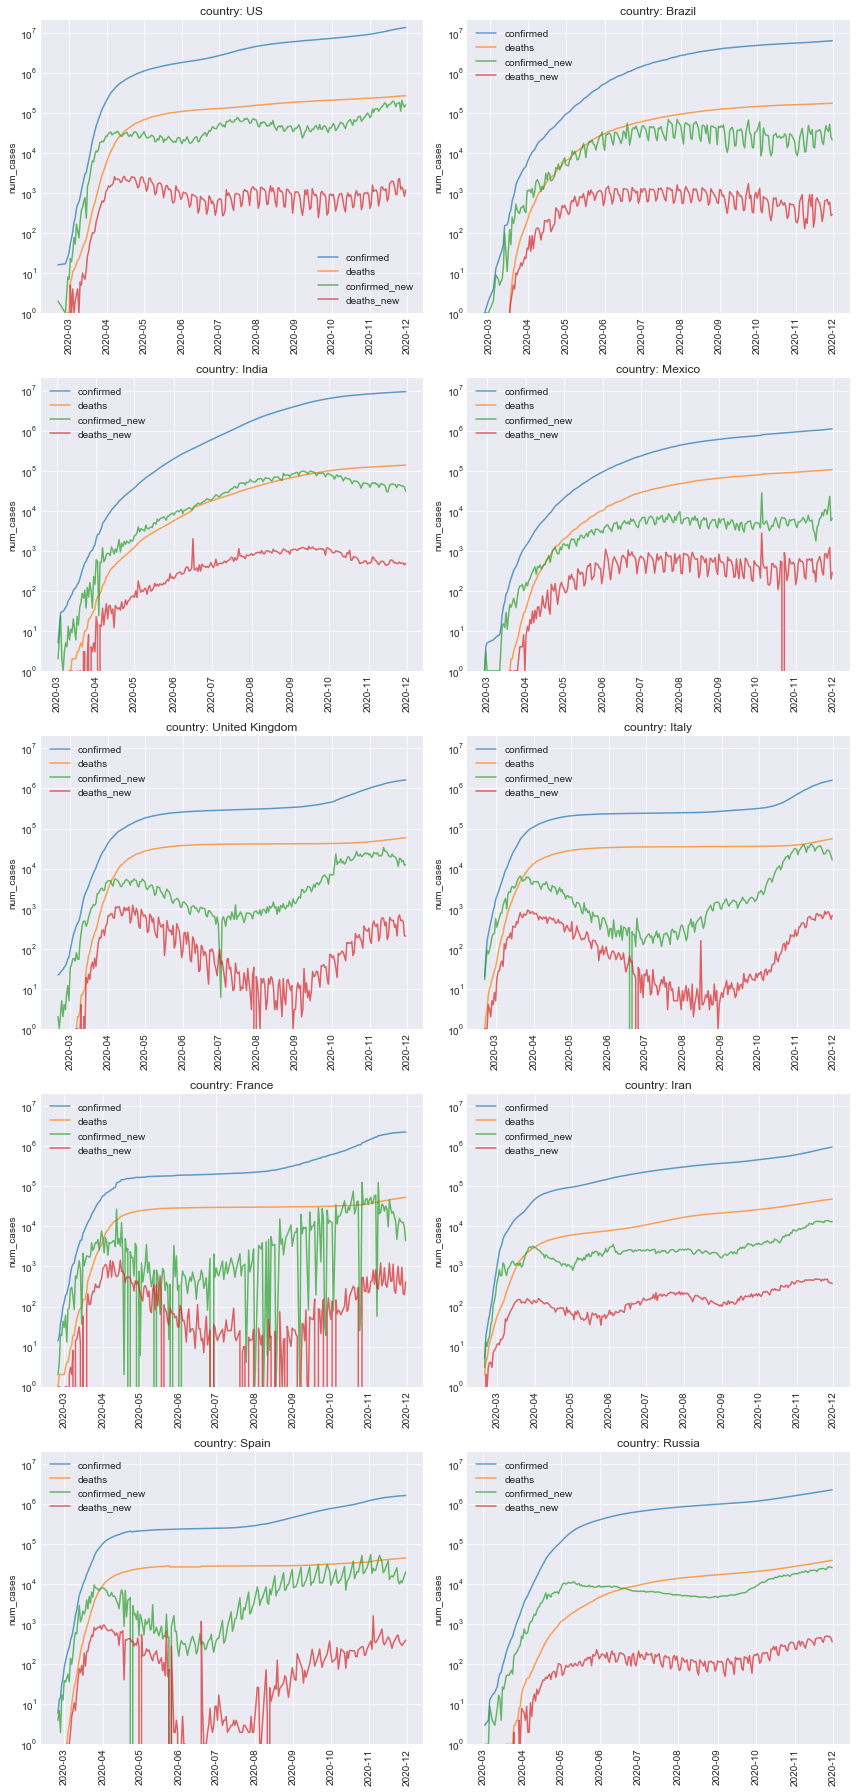

In [251]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

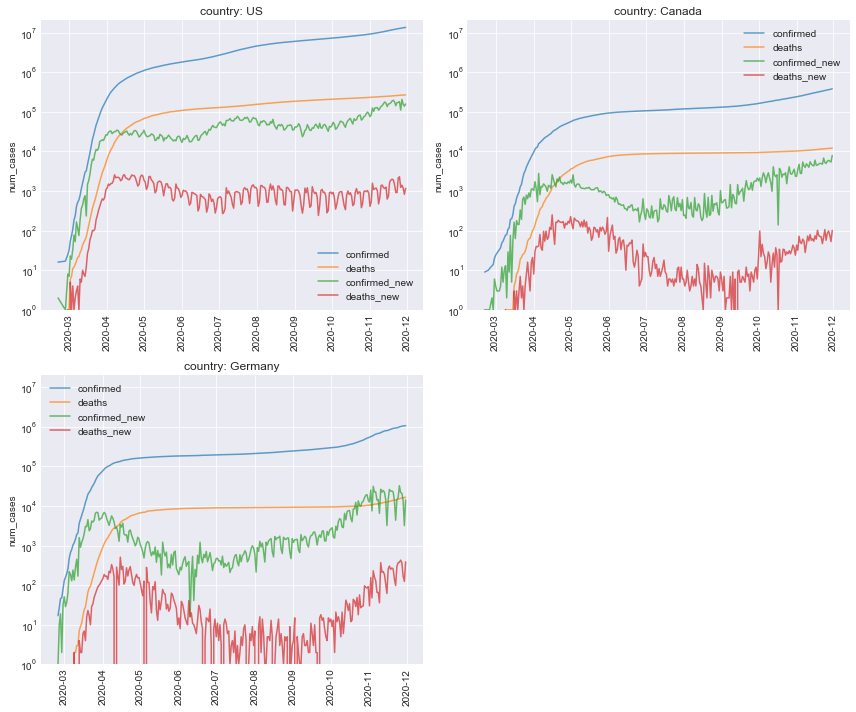

In [252]:
plot_countries(dfp_country, 
               countries=['US', 'Canada', 'Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [253]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1, cols_to_be_null_in_future=[]):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    cols_nullable = ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']
    cols_nullable.extend(cols_to_be_null_in_future)
    for col in cols_nullable:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

In [254]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
#plot_forecasts(dfp_country_recent_1)

confirmed_pred                         deaths_pred             \
date               2020-12-01  2020-12-07  2020-12-21  2020-12-01 2020-12-07   
country                                                                        
US                 13717281.0  14751721.0  17479012.0    269712.0   277762.0   
Brazil              6387542.0   6618679.0   7191051.0    173878.0   176997.0   
India               9511419.0   9762196.0  10373357.0    138135.0   141118.0   
Mexico              1124156.0   1182351.0   1330127.0    106705.0   110025.0   
United Kingdom      1653000.0   1750489.0   2000914.0     59254.0    62030.0   
Italy               1636778.0   1806163.0   2272723.0     56459.0    61192.0   
France              2292918.0   2366215.0   2546482.0     53392.0    56140.0   
Iran                 977410.0   1067955.0   1313198.0     48736.0    51396.0   
Spain               1652698.0   1700849.0   1818726.0     45280.0    46557.0   
Russia              2303473.0   2473618.0   2921115.0     40088.0    43212.0   

                          mortality_rate_pred                        \
date           2020-12-21          2020-12-01 2020-12-07 2020-12-21   
country                                                               
US               297492.0            0.019662   0.018829   0.017020   
Brazil           184493.0            0.027221   0.026742   0.025656   
India            148333.0            0.014523   0.014456   0.014299   
Mexico           118179.0            0.094920   0.093056   0.088848   
United Kingdom    69026.0            0.035846   0.035436   0.034497   
Italy             73837.0            0.034494   0.033880   0.032488   
France            63114.0            0.023286   0.023726   0.024785   
Iran              58180.0            0.049862   0.048126   0.044304   
Spain             49678.0            0.027398   0.027373   0.027315   
Russia            51484.0            0.017403   0.017469   0.017625   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.012191             0.004914  
Brazil                        0.005942             0.002967  
India                         0.004347             0.003568  
Mexico                        0.008448             0.005120  
United Kingdom                0.009596             0.007662  
Italy                         0.016548             0.013507  
France                        0.005258             0.008399  
Iran                          0.014875             0.008895  
Spain                         0.004798             0.004646  
Russia                        0.011948             0.012588

In [255]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-11-30_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [256]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


In [257]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
#find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

In [258]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
#plot_forecasts(dfp_country_recent_2)

confirmed_pred             deaths_pred             \
date               2020-12-01  2020-12-07  2020-12-01 2020-12-07   
country                                                            
US                 13788450.0  14942302.0    270561.0   280090.0   
Brazil              6374128.0   6582553.0    173821.0   176872.0   
India               9523152.0   9792598.0    138252.0   141406.0   
Mexico              1120928.0   1174843.0    106781.0   110273.0   
United Kingdom      1663588.0   1777162.0     59349.0    62327.0   
Italy               1659698.0   1866912.0     56548.0    61471.0   
France              2304186.0   2392728.0     53783.0    57259.0   
Iran                 979527.0   1073800.0     48935.0    51939.0   
Spain               1662707.0   1728727.0     45487.0    47207.0   
Russia              2302456.0   2470584.0     40083.0    43201.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-12-01 2020-12-07                           
country                                                                 
US                        0.019622   0.018745                0.013484   
Brazil                    0.027270   0.026870                0.005377   
India                     0.014517   0.014440                0.004661   
Mexico                    0.095261   0.093862                0.007860   
United Kingdom            0.035675   0.035071                0.011068   
Italy                     0.034071   0.032927                0.019802   
France                    0.023341   0.023930                0.006304   
Iran                      0.049958   0.048369                0.015433   
Spain                     0.027357   0.027307                0.006511   
Russia                    0.017409   0.017486                0.011816   

               frac_increase_deaths  
date                                 
country                              
US                         0.005785  
Brazil                     0.002904  
India                      0.003767  
Mexico                     0.005378  
United Kingdom             0.008195  
Italy                      0.014010  
France                     0.010495  
Iran                       0.009979  
Spain                      0.006204  
Russia                     0.012561

In [259]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-11-30_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [260]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

In [261]:
# n_countries = 8
# countries = dfp_top_countries.iloc[:n_countries]['country']

# plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [262]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

In [263]:
# plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [264]:
dfp_3codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
dfp_3codes.columns = list([x.lower() for x in dfp_3codes.columns])
dfp_3codes = dfp_3codes.rename(columns={'code': 'country_code'})

In [265]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})

# decorate with country codes
dfp_demo_decade = dfp_demo_decade.merge(dfp_3codes[['country', 'country_code']], on='country', how='left')

# ensure consistency with Johns Hopkins data
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']

grouping_cols_country = ['country', 'country_code']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(grouping_cols_country, as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

In [266]:
# n_countries = 8
# countries = dfp_top_countries.iloc[:n_countries]['country']
# for country in countries:
#     dfp_plot = dfp_demo[dfp_demo.country == country]
#     plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
# plt.xlabel('age')
# plt.ylabel('% of population')
# plt.title('Age distribution by country')
# plt.legend(loc='best')
# plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

In [267]:
# n_countries = 10
# countries = dfp_top_countries.iloc[:n_countries]['country']

# plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
# dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
#                            (dfp_country['country'].isin(countries))
#                           ].
#                sort_values(by='mortality_rate', ascending=0).
#                reset_index(drop=True)
#               )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
# display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

In [268]:
# dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
# plt.title('Distribution of mortality fraction')
# plt.ylabel('number of countries')
# plt.xlabel('mortality fraction')
# plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [269]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country country_code  frac_mortality  num_deaths_max_expected  \
1         Japan          JPN        0.031837              3998380.024   
2       Germany          DEU        0.026398              2128411.026   
3        Greece          GRC        0.025745               271233.247   
4         Italy          ITA        0.025637              1599267.592   
10     Portugal          PRT        0.023736               244829.259   
18       France          FRA        0.022950              1564984.503   
20       Sweden          SWE        0.022575               231555.716   
23      Belgium          BEL        0.022146               259573.363   
24  Netherlands          NLD        0.022076               382222.125   
27       Canada          CAN        0.021712               820035.480   

          pop  
1   125507472  
2    80159662  
3    10607051  
4    62402659  
10   10302674  
18   67848156  
20   10202491  
23   11720716  
24   17280397  
27   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [270]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[grouping_cols_country + ['pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

# new infections
dfp_country_pop['deaths_new_per_million'] = dfp_country_pop['deaths_new'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_new_per_million'] = dfp_country_pop['confirmed_new'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['deaths_new_per_million_smooth'] = dfp_country_pop['deaths_new_smooth'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_new_per_million_smooth'] = dfp_country_pop['confirmed_new_smooth'] / dfp_country_pop['pop'] * 1E6

### Map: new confirmed cases and deaths

In [271]:
def plot_world_map(df, plot_col, color='Reds', col_country='country_code'):
    # this was adapted from example at https://plotly.com/python/choropleth-maps/
    import plotly.graph_objects as go
    fig = go.Figure(data=go.Choropleth(
        locations=df[col_country], #df['code'], # Spatial coordinates
        z = df[plot_col].astype(float), # Data to be color-coded
        #locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = color,
        colorbar_title = plot_col,
    ))

    fig.update_layout(
        title_text = plot_col,
        #geo_scope='usa', # limite map scope to USA
    )

    fig.show()
    return None

In [272]:
plot_world_map(dfp_country_pop[dfp_country_pop.date == ds_latest], 'confirmed_new_per_million_smooth')

In [273]:
plot_world_map(dfp_country_pop[dfp_country_pop.date == ds_latest], 'deaths_new_per_million_smooth')

In [274]:
def plot_smoothed_trend(
    dfp_us_g, 
    states, 
    cols_plot=['confirmed_new'], 
    dt_start=datetime.datetime(2020,3,1), 
    state_col='state'
):
    
    for state in states:
        i = 1
        for col_plot in cols_plot:
            plt.subplot(1,len(cols_plot),i)
            col_plot_smooth = f'{col_plot}_smooth'
            dfp_plot = dfp_us_g[(dfp_us_g[state_col] == state) & (dfp_us_g['date'] >= dt_start)]
            plt.plot(dfp_plot['date'], dfp_plot[col_plot], alpha=0.5, label=col_plot)
            plt.plot(dfp_plot['date'], dfp_plot[col_plot_smooth], label=col_plot_smooth)
            plt.legend(loc='best')
            plt.xticks(rotation=90)
            plt.ylabel(col_plot)
            plt.title(f'{state} {col_plot}')
            plt.ylim(ymin=0)
            i += 1
        plt.tight_layout()
        plt.show()
    return None

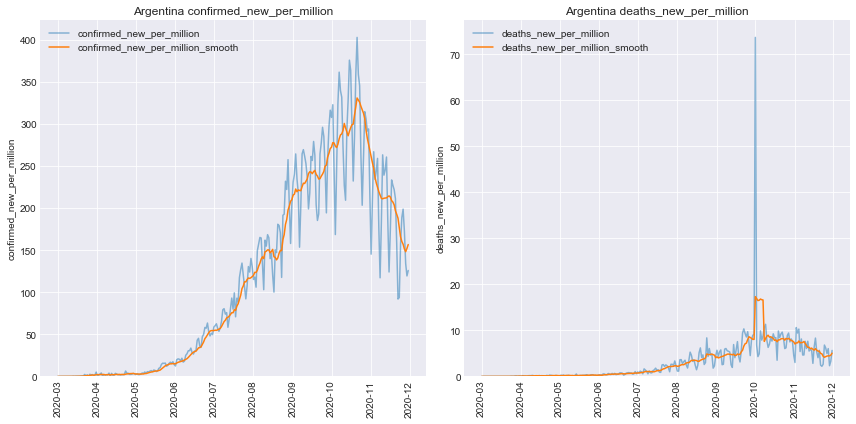

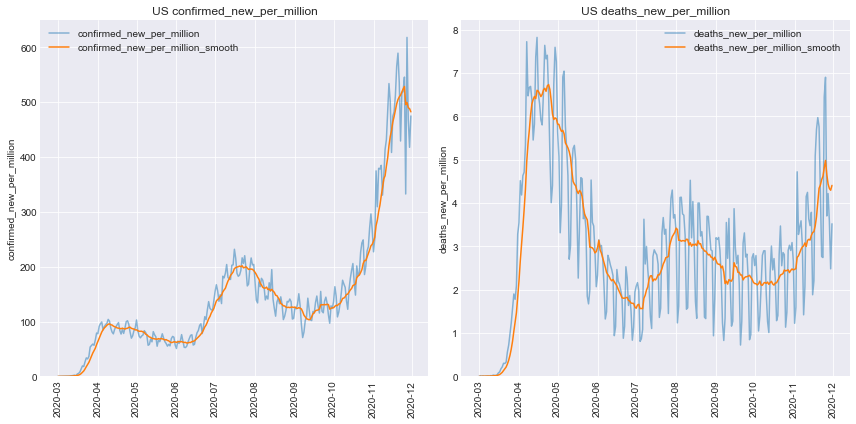

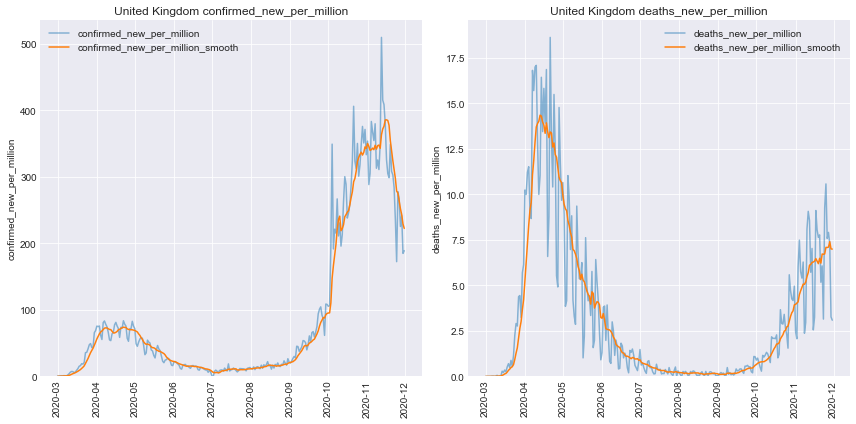

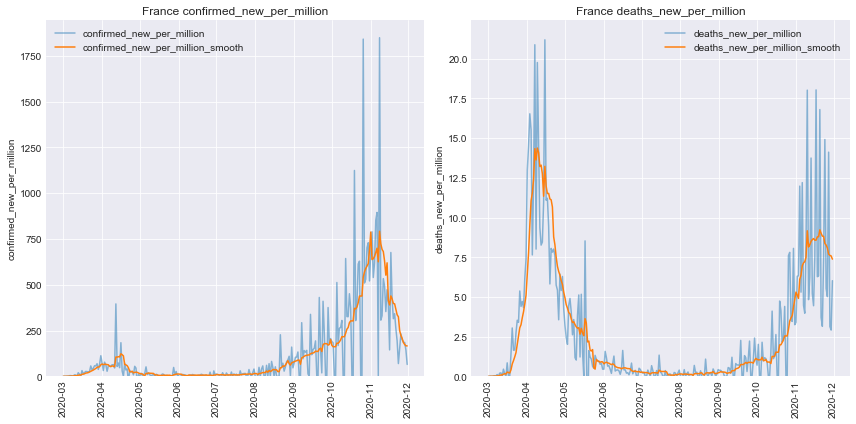

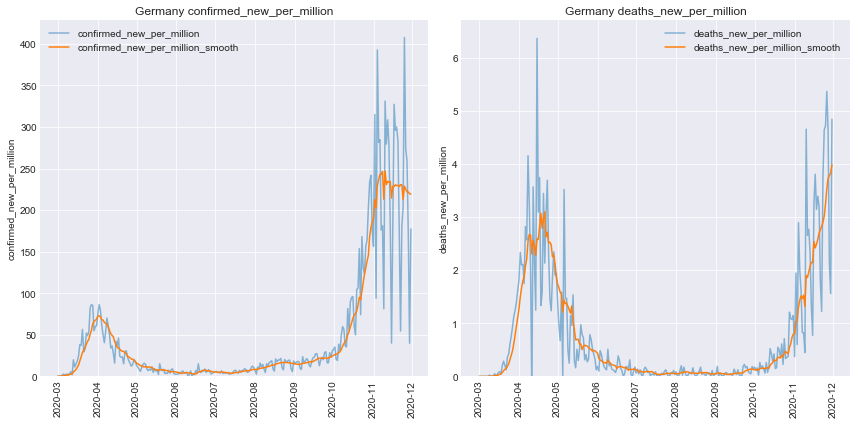

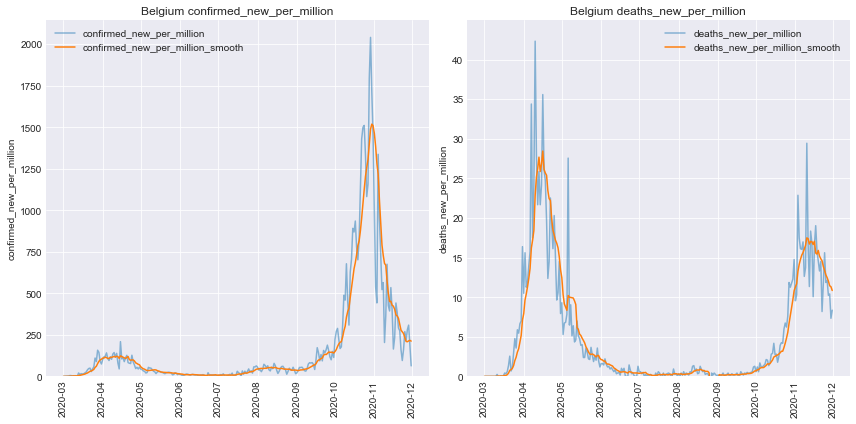

In [275]:
plot_smoothed_trend(
    dfp_country_pop, 
    state_col='country', 
    states=['Argentina', 'US', 'United Kingdom', 'France', 'Germany', 'Belgium'], 
    cols_plot=['confirmed_new_per_million', 'deaths_new_per_million']
)

##### Top countries by per-capita

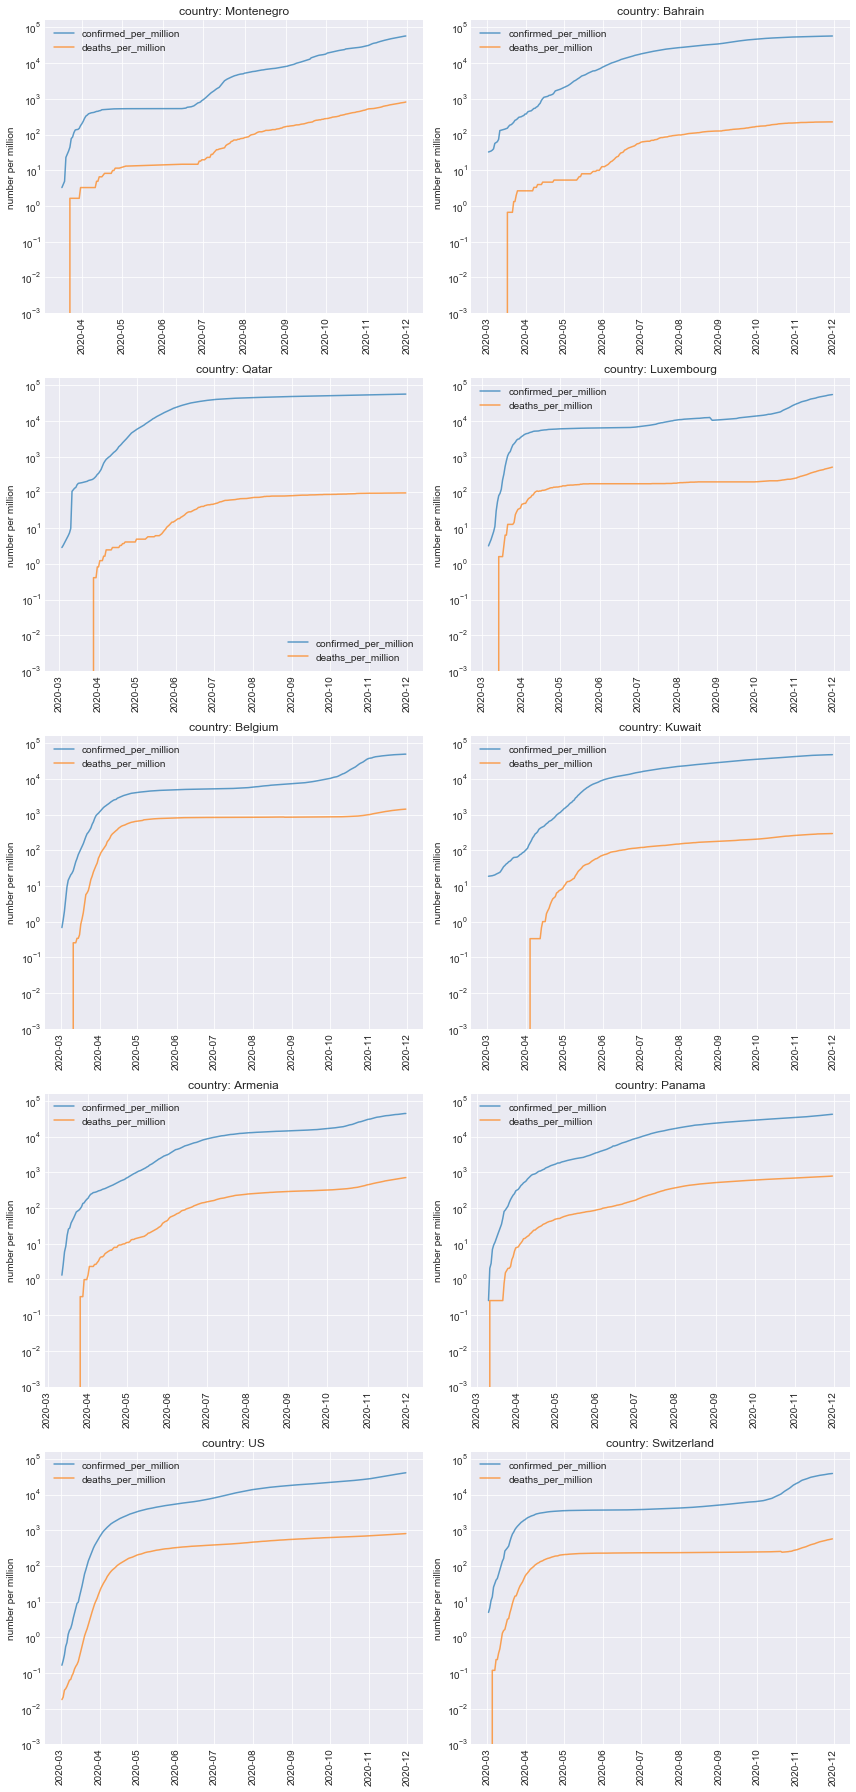

country   population   confirmed    deaths  confirmed_per_million  \
0   Montenegro     609859.0     35265.0     499.0           57824.841480   
1      Bahrain    1505003.0     86956.0     341.0           57777.957918   
2        Qatar    2444174.0    138833.0     237.0           56801.602505   
3   Luxembourg     628381.0     34678.0     321.0           55186.264384   
4      Belgium   11720716.0    577345.0   16645.0           49258.509463   
5       Kuwait    2993706.0    142635.0     880.0           47644.959124   
6      Armenia    3021324.0    135124.0    2164.0           44723.439128   
7       Panama    3894082.0    165806.0    3079.0           42578.969832   
8           US  332639102.0  13541221.0  268045.0           40708.446237   
9  Switzerland    8403994.0    327072.0    4815.0           38918.637971   

   deaths_per_million  mortality_rate  
0          818.221917        0.014150  
1          226.577621        0.003922  
2           96.965273        0.001707  
3          510.836578        0.009257  
4         1420.135084        0.028830  
5          293.950041        0.006170  
6          716.242283        0.016015  
7          790.686996        0.018570  
8          805.813262        0.019795  
9          572.941865        0.014722

In [276]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [277]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop  confirmed    deaths  confirmed_per_million  \
4          Belgium   11720716.0   577345.0   16645.0           49258.509463   
22            Peru   31914989.0   962530.0   35923.0           30159.183198   
15           Spain   50015792.0  1648187.0   45069.0           32953.332020   
29           Italy   62402659.0  1601554.0   55576.0           25664.835853   
31  United Kingdom   65761117.0  1633733.0   58545.0           24843.449663   
18       Argentina   45479118.0  1424533.0   38730.0           31322.793023   
21           Chile   18186770.0   551743.0   15410.0           30337.602554   
73          Mexico  128649565.0  1113543.0  105940.0            8655.629733   
0       Montenegro     609859.0    35265.0     499.0           57824.841480   
23          Brazil  211715973.0  6335878.0  173120.0           29926.310756   

    deaths_per_million  mortality_rate  
4          1420.135084        0.028830  
22         1125.583969        0.037321  
15          901.095398        0.027345  
29          890.603075        0.034701  
31          890.267725        0.035835  
18          851.599629        0.027188  
21          847.319233        0.027930  
73          823.477328        0.095138  
0           818.221917        0.014150  
23          817.699286        0.027324

### Mortality rate by deaths per capita, confirmed per capita

In [278]:
# plot_mortality_rate_vs_infections(dfp_country_pop, 
#                                   countries, 
#                                   upper_lim=0.2, 
#                                   id_col='country', 
#                                   date_min=datetime.datetime(2020,3,1), 
#                                   x_col='deaths_per_million', 
#                                   y_col='mortality_rate'
#                                  )

In [279]:
# plot_mortality_rate_vs_infections(dfp_country_pop, 
#                                   countries, 
#                                   upper_lim=0.2, 
#                                   id_col='country', 
#                                   date_min=datetime.datetime(2020,3,1), 
#                                   x_col='confirmed_per_million', 
#                                   y_col='mortality_rate'
#                                  )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [280]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

In [281]:
# _ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

In [282]:
# _ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [283]:
# # load and clean data
# dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
# dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
#                                         'positive': 'confirmed',
#                                         'death': 'deaths',
#                                         'date': 'date_str'
#                                        })
# dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
# dfp_us_raw['country'] = 'US'

In [284]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered', 'people_hospitalized']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update',
                      'People_Hospitalized': 'people_hospitalized'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    #dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    
    dfp_temp['date'] = datetime.datetime.strptime(path.split('.')[0], '%m-%d-%Y')
    #dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [285]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')
# dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
# dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# # aggregate infections by state
# dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
#             agg({
#                 'confirmed': np.sum,
#                 'deaths': np.sum,
#                 #'recovered': np.sum,
#                })
#            )
# dfp_us_g.shape

In [286]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [287]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date           state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-11-30        New York     647980           6819   34605          44   
1  2020-11-30           Texas    1238752          13634   21896          53   
2  2020-11-30      California    1230264          14809   19173          22   
3  2020-11-30         Florida     999319           6659   18597          97   
4  2020-11-30      New Jersey     337304           3190   16993          15   
5  2020-11-30        Illinois     726304           6190   12985         103   
6  2020-11-30   Massachusetts     226132           1168   10748          26   
7  2020-11-30    Pennsylvania     366835           5891   10335          38   
8  2020-11-30        Michigan     388942          10790    9564          97   
9  2020-11-30         Georgia     471563           2047    9452          10   
10 2020-11-30         Arizona     326817            822    6639           5   
11 2020-11-30            Ohio     421063           6631    6429          30   
12 2020-11-30       Louisiana     232414            169    6420          13   
13 2020-11-30         Indiana     338977           5665    5723          38   
14 2020-11-30  North Carolina     364512           2734    5261          21   

    mortality_rate  
0         0.053404  
1         0.017676  
2         0.015584  
3         0.018610  
4         0.050379  
5         0.017878  
6         0.047530  
7         0.028173  
8         0.024590  
9         0.020044  
10        0.020314  
11        0.015268  
12        0.027623  
13        0.016883  
14        0.014433

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [288]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

In [289]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
# plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
# plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
# plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
# plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

In [290]:
# plot_countries(dfp_us_g, 
#                countries=dfp_us_top_states.iloc[:10]['state'].values,
#                plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
#                country_col='state',
#                date_min=datetime.datetime(2020,3,11),
#                y_max=dfp_us_g['confirmed'].max()
#               )

In [291]:
# plot_countries(dfp_us_g, 
#                countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
#                plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
#                country_col='state',
#                date_min=datetime.datetime(2020,3,11),
#                y_max=dfp_us_g['confirmed'].max()
#               )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

In [292]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
# plot_forecasts(dfp_state_recent_1, 
#                    n_countries=10, 
#                    n_columns=2, 
#                    figsize=(12,24), 
#                    date_min=datetime.datetime(2020, 2, 1),
#                    col_locale='state',
#                   )

confirmed_pred                       deaths_pred             \
date              2020-12-01 2020-12-07 2020-12-21  2020-12-01 2020-12-07   
state                                                                       
New York            655523.0   700195.0   816628.0     34642.0    34890.0   
Texas              1243908.0  1297741.0  1432586.0     22066.0    22706.0   
California         1244258.0  1335717.0  1576123.0     19254.0    19558.0   
Florida            1008475.0  1059223.0  1187792.0     18653.0    19094.0   
New Jersey          341944.0   367595.0   435180.0     17036.0    17198.0   
Illinois            738289.0   794826.0   944159.0     13148.0    13905.0   
Massachusetts       229710.0   246826.0   291890.0     10777.0    10974.0   
Pennsylvania        375866.0   423030.0   557389.0     10428.0    10820.0   
Michigan            396309.0   445611.0   585834.0      9660.0    10184.0   
Georgia             475415.0   493276.0   537606.0      9518.0     9755.0   

                         mortality_rate_pred                        \
date          2020-12-21          2020-12-01 2020-12-07 2020-12-21   
state                                                                
New York         35474.0            0.052846   0.049829   0.043440   
Texas            24271.0            0.017739   0.017497   0.016942   
California       20285.0            0.015474   0.014642   0.012870   
Florida          20162.0            0.018496   0.018026   0.016974   
New Jersey       17581.0            0.049821   0.046785   0.040399   
Illinois         15846.0            0.017809   0.017494   0.016783   
Massachusetts    11447.0            0.046916   0.044460   0.039217   
Pennsylvania     11794.0            0.027744   0.025577   0.021159   
Michigan         11522.0            0.024375   0.022854   0.019668   
Georgia          10330.0            0.020020   0.019776   0.019215   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.011048             0.001188  
Texas                        0.007086             0.004774  
California                   0.011892             0.002612  
Florida                      0.008216             0.003895  
New Jersey                   0.012129             0.001576  
Illinois                     0.012374             0.009376  
Massachusetts                0.012050             0.003019  
Pennsylvania                 0.019897             0.006176  
Michigan                     0.019734             0.008853  
Georgia                      0.006166             0.004100

##### 2 weeks of data

In [293]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
# plot_forecasts(dfp_state_recent_2, 
#                    n_countries=10, 
#                    n_columns=2, 
#                    figsize=(12,24), 
#                    date_min=datetime.datetime(2020, 2, 1),
#                    col_locale='state',
#                   )

confirmed_pred                       deaths_pred             \
date              2020-12-01 2020-12-07 2020-12-21  2020-12-01 2020-12-07   
state                                                                       
New York            653185.0   693717.0   798341.0     34616.0    34818.0   
Texas              1254756.0  1327921.0  1515662.0     22210.0    23089.0   
California         1245044.0  1338528.0  1584870.0     19311.0    19712.0   
Florida            1008889.0  1059833.0  1188932.0     18656.0    19100.0   
New Jersey          343106.0   370787.0   444376.0     17047.0    17233.0   
Illinois            747016.0   818349.0  1012415.0     13214.0    14081.0   
Massachusetts       230081.0   247687.0   294184.0     10764.0    10936.0   
Pennsylvania        377426.0   427482.0   571636.0     10490.0    10984.0   
Michigan            397957.0   449660.0   597947.0      9661.0    10195.0   
Georgia             477367.0   498323.0   550866.0      9506.0     9719.0   

                         mortality_rate_pred                        \
date          2020-12-21          2020-12-01 2020-12-07 2020-12-21   
state                                                                
New York         35294.0            0.052996   0.050190   0.044209   
Texas            25277.0            0.017701   0.017387   0.016677   
California       20681.0            0.015510   0.014727   0.013049   
Florida          20178.0            0.018492   0.018022   0.016972   
New Jersey       17675.0            0.049684   0.046477   0.039775   
Illinois         16333.0            0.017689   0.017207   0.016133   
Massachusetts    11349.0            0.046784   0.044152   0.038578   
Pennsylvania     12229.0            0.027794   0.025695   0.021393   
Michigan         11559.0            0.024276   0.022673   0.019331   
Georgia          10236.0            0.019913   0.019503   0.018582   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.010084             0.000971  
Texas                        0.009490             0.006489  
California                   0.012140             0.003434  
Florida                      0.008244             0.003930  
New Jersey                   0.013016             0.001810  
Illinois                     0.015316             0.010651  
Massachusetts                0.012364             0.002651  
Pennsylvania                 0.020973             0.007701  
Michigan                     0.020567             0.009006  
Georgia                      0.007186             0.003708

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [294]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [295]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'confirmed_new', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  confirmed_new  \
0  2020-11-30          South Dakota      80464     946            564   
1  2020-11-30            New Mexico      97095    1568           1678   
2  2020-11-30             Minnesota     318763    3652           5794   
3  2020-11-30               Vermont       4172      69             72   
4  2020-11-30                  Guam       6852     112             84   
5  2020-11-30              Nebraska     128407    1018           1941   
6  2020-11-30                  Utah     195706     871           1897   
7  2020-11-30         West Virginia      47842     735            845   
8  2020-11-30                Oregon      75431     912           1312   
9  2020-11-30             Wisconsin     411730    3494           2676   
10 2020-11-30               Montana      62198     681            397   
11 2020-11-30           Puerto Rico      52545    1106            843   
12 2020-11-30                  Iowa     230631    2426           1941   
13 2020-11-30               Indiana     338977    5723           5665   
14 2020-11-30              Michigan     388942    9564          10790   
15 2020-11-30              Illinois     726304   12985           6190   
16 2020-11-30                 Idaho     101698     929           1214   
17 2020-11-30                Kansas     159915    1560           4415   
18 2020-11-30              Kentucky     179041    1908           2116   
19 2020-11-30          North Dakota      79252     933            594   
20 2020-11-30              Colorado     232905    3037           4133   
21 2020-11-30                Alaska      32576     121            511   
22 2020-11-30                Nevada     152171    2144           1644   
23 2020-11-30              Oklahoma     197745    1743           2200   
24 2020-11-30                  Ohio     421063    6429           6631   
25 2020-11-30                Hawaii      18223     244             85   
26 2020-11-30               Wyoming      33305     215            816   
27 2020-11-30             Tennessee     374493    4602           7975   
28 2020-11-30        North Carolina     364512    5261           2734   
29 2020-11-30              Maryland     198370    4641           1923   
30 2020-11-30          Pennsylvania     366835   10335           5891   
31 2020-11-30              Arkansas     157359    2502           1112   
32 2020-11-30                 Texas    1238752   21896          13634   
33 2020-11-30         New Hampshire      21030     526            514   
34 2020-11-30          Rhode Island      56723    1373           2769   
35 2020-11-30               Georgia     471563    9452           2047   
36 2020-11-30              Missouri     306206    3861           3797   
37 2020-11-30               Florida     999319   18597           6659   
38 2020-11-30           Mississippi     153270    3807           1485   
39 2020-11-30           Connecticut     117295    5020           4714   
40 2020-11-30               Arizona     326817    6639            822   
41 2020-11-30               Alabama     249524    3578           2295   
42 2020-11-30              Delaware      35654     772            403   
43 2020-11-30        South Carolina     217487    4381           1358   
44 2020-11-30            California    1230264   19173          14809   
45 2020-11-30              Virginia     237835    4062           1893   
46 2020-11-30             Louisiana     232414    6420            169   
47 2020-11-30                 Maine      11757     194            249   
48 2020-11-30         Massachusetts     226132   10748           1168   
49 2020-11-30            Washington     165019    2774           2319   
50 2020-11-30            New Jersey     337304   16993           3190   
51 2020-11-30  District of Columbia      21552     680            104   
52 2020-11-30              New York     647980   34605           6819   
53 2020-11-30        Virgin Islands       1544      23             

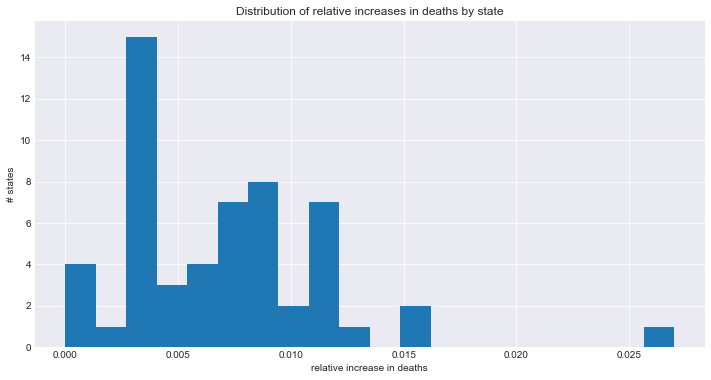

In [296]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

In [297]:
# plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
# #plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('relative increase in deaths per day')
# plt.ylabel('# deaths')
# plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
# plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [298]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

In [299]:
# _ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
#                               'Washington', 
#                               dfp=dfp_us_g, 
#                               country_col='state', 
#                               compare_col='confirmed'
#                              )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

In [300]:
# _ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
#                               'New York', 
#                               dfp=dfp_us_g, 
#                               country_col='state', 
#                               compare_col='confirmed'
#                              )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

In [301]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

#plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

In [302]:
#plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

In [303]:
#find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [304]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n, cols_to_be_null_in_future=fit_cols)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                        n_countries=10, 
                        n_columns=2, 
                        figsize=(12,24), 
                        date_min=datetime.datetime(2020, 2, 1),
                        col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                       cols_deaths='deaths_new',
                       frac_increase_col='frac_increase_deaths',
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    else:
        n_countries = len(top_countries)
        
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={cols_deaths})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs[frac_increase_col].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest[f'{cols_deaths}_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [305]:
n_days_training = 21
dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None,
                                                      fit_cols=['confirmed_new_smooth', 'deaths_new_smooth'],
                                                   )

confirmed_new_smooth_pred                                   \
date                         2020-12-01 2020-12-07 2020-12-14 2020-12-28   
state                                                                      
California                        16931      22218      30505      57508   
Texas                             11879      12713      13759      16119   
Illinois                           9866       9197       8473       7192   
Florida                            8802      10169      12034      16854   
Pennsylvania                       7952       9709      12256      19527   
Michigan                           7448       7802       8236       9178   
New York                           6856       8221      10159      15513   
New Jersey                         4544       5169       6007       8113   
Georgia                            3518       3884       4359       5492   
Massachusetts                      2750       2927       3147       3639   

                                                                      \
date          2021-01-25 2021-02-22 2021-03-22 2021-04-19 2021-05-17   
state                                                                  
California        204374     726312    2581193    9173128   32599759   
Texas              22121      30357      41660      57172      78460   
Illinois            5182       3734       2690       1938       1396   
Florida            33058      64838     127171     249427     489214   
Pennsylvania       49568     125825     319399     810774    2058095   
Michigan           11397      14153      17575      21825      27101   
New York           36176      84361     196723     458743    1069752   
New Jersey         14799      26994      49238      89813     163824   
Georgia             8715      13829      21945      34823      55259   
Massachusetts       4866       6506       8699      11631      15551   

                         deaths_new_smooth_pred                        \
date          2021-07-12             2020-12-01 2020-12-07 2020-12-14   
state                                                                   
California     411725922                     75         90        112   
Texas             147764                    148        161        179   
Illinois             725                    152        186        234   
Florida          1881957                     76         84         95   
Pennsylvania    13261610                     94        127        179   
Michigan           41791                     91        108        131   
New York         5817159                     41         50         64   
New Jersey        545067                     40         55         78   
Georgia           139145                     31         29         26   
Massachusetts      27802                     29         31         34   

                                                                      \
date          2020-12-28 2021-01-25 2021-02-22 2021-03-22 2021-04-19   
state                                                                  
California           173        411        977       2321       5511   
Texas                221        335        508        770       1167   
Illinois             371        933       2346       5898      14828   
Florida              120        194        313        504        812   
Pennsylvania         355       1394       5480      21533      84604   
Michigan             193        418        906       1963       4250   
New York             103        270        704       1833       4772   
New Jersey           157        640       2601      10566      42917   
Georgia               22         15         10          7          5   
Massachusetts         40         56         78        109        152   

                                    frac_increase_confirmed  \
date          2021-05-17 2021-07-12                           
state                                                         
California  

In [306]:
#dfp_us_recent_1[dfp_us_recent_1.date == '2020-05-29'].sort_values(by='deaths_new_pred', ascending=0).reset_index(drop=True)

##### Fraction of increase in confirmed cases

In [307]:
# plot_forecasts_new(
#     dfp_us_recent_1, 
#     col_locale='state', 
#     top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin', 'Arizona', 'South Carolina', 'North Carolina', 'Texas'],
#     cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
#     cols_deaths='deaths_new_smooth',
#     frac_increase_col='frac_increase_confirmed'
# )

##### Fraction increase in deaths_new

In [308]:
# plot_forecasts_new(
#     dfp_us_recent_1, 
#     col_locale='state', 
#     top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin', 'Arizona', 'South Carolina', 'North Carolina', 'Texas'],
#     cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
#     cols_deaths='deaths_new_smooth',
#     frac_increase_col='frac_increase_deaths'
# )

In [309]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-11-30_n_days_training=21.csv


<a id='us_state_smoothed_trend'></a>
### Plot trends

In [310]:
dfp_us_g_new_confirmed = dfp_us_g[dfp_us_g['date'] > datetime.datetime(2020,4,1)].groupby('state', as_index=False).agg({'confirmed_new': np.sum})
states_minimum_thresh = dfp_us_g_new_confirmed[(dfp_us_g_new_confirmed['confirmed_new'] > 100)].state

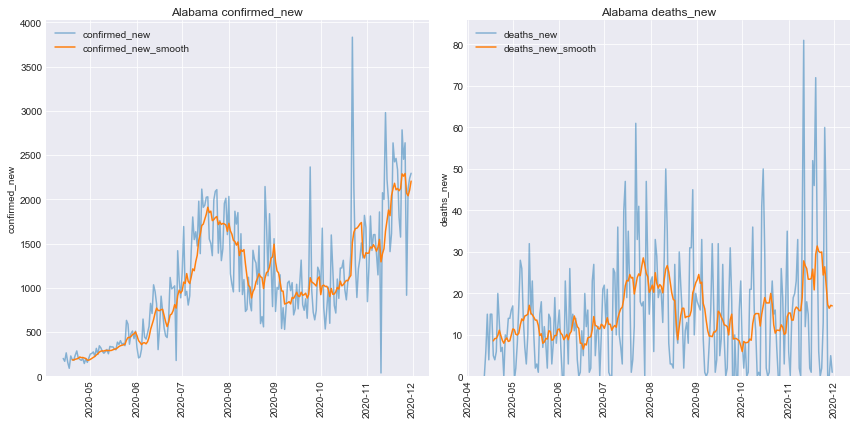

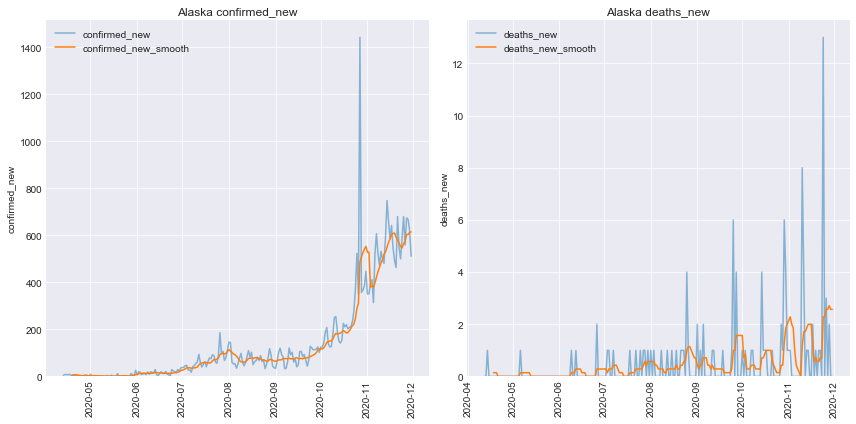

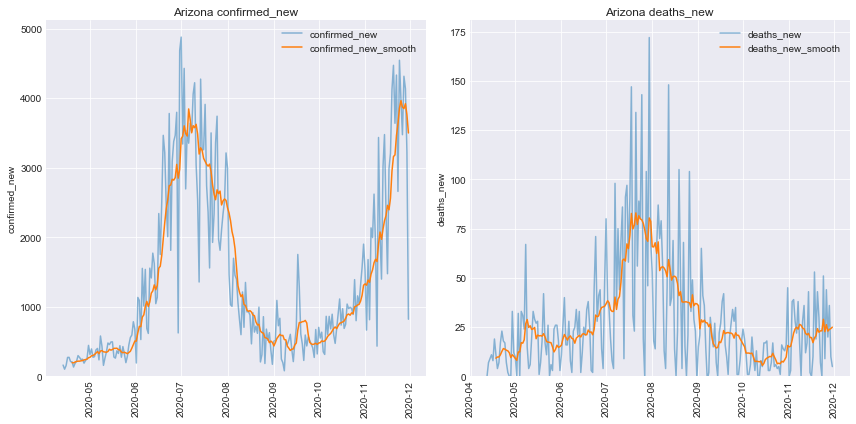

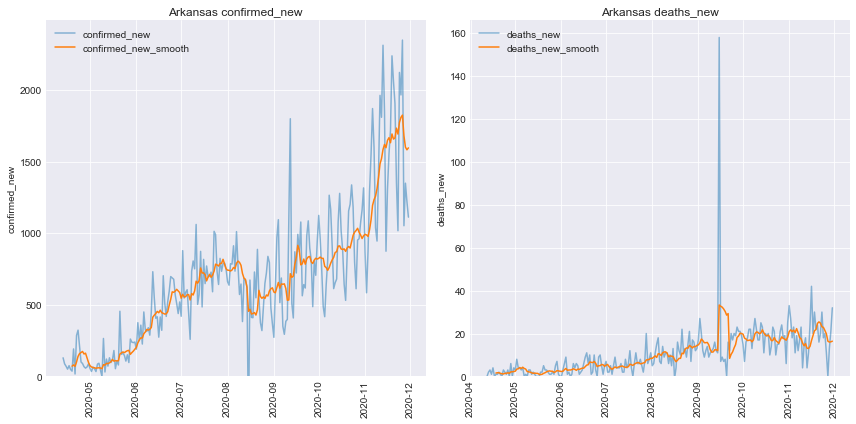

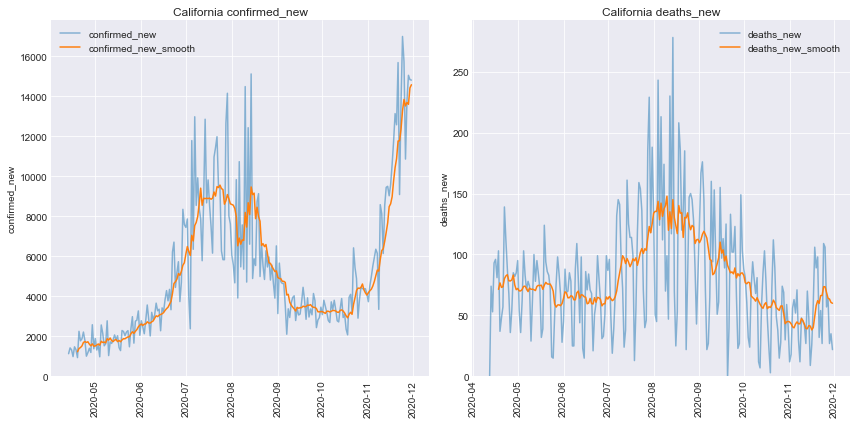

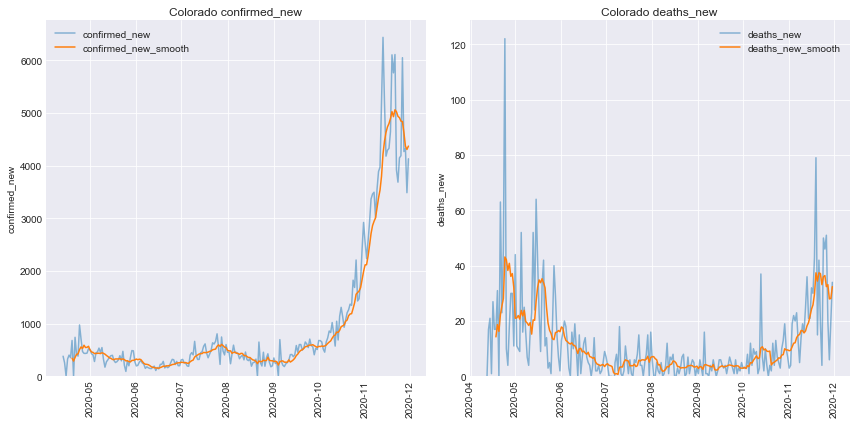

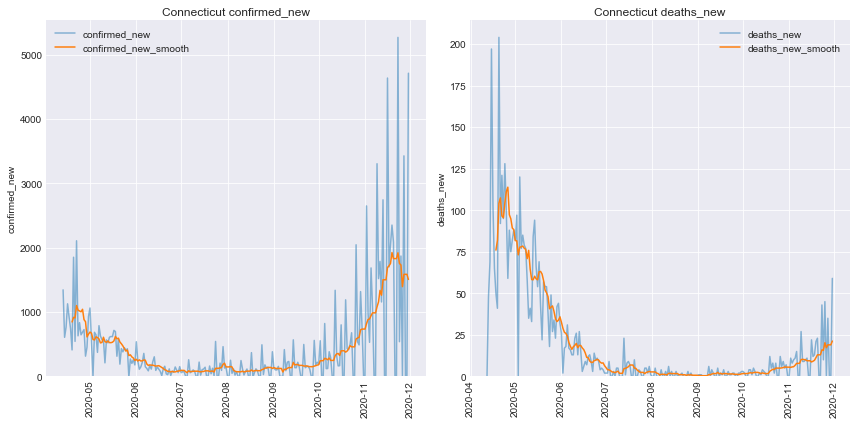

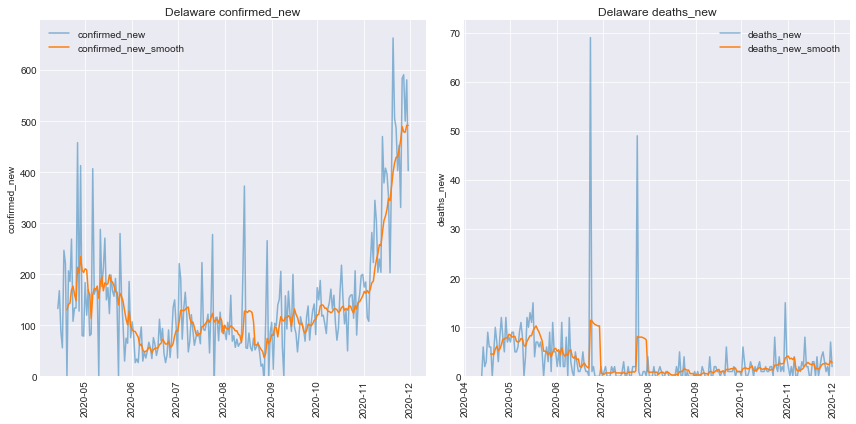

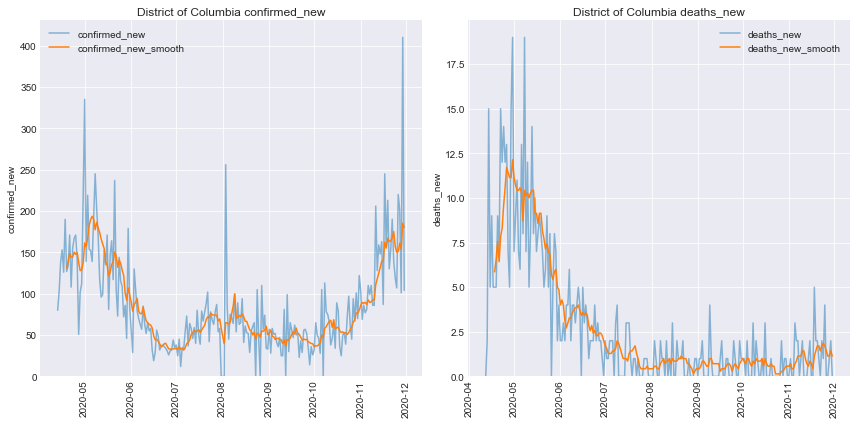

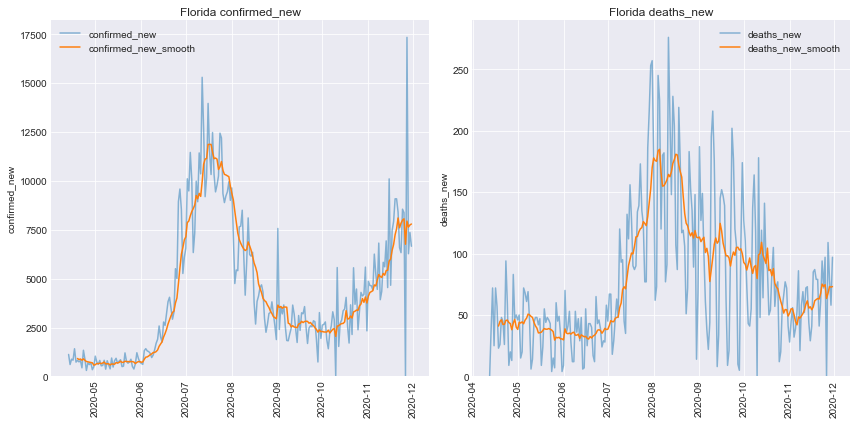

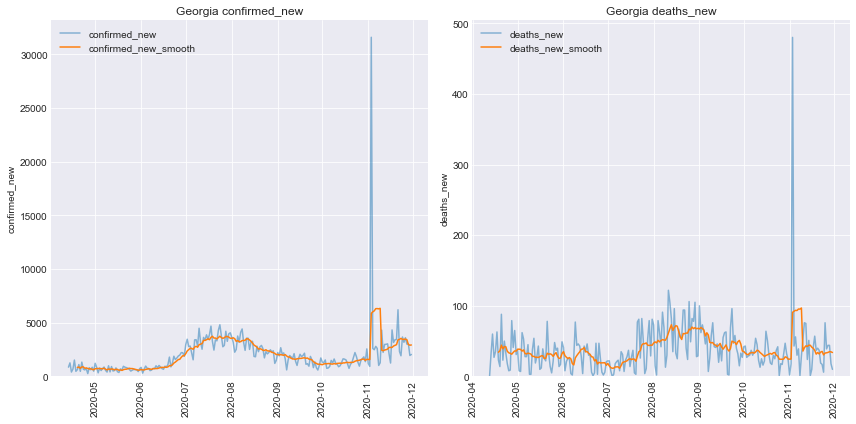

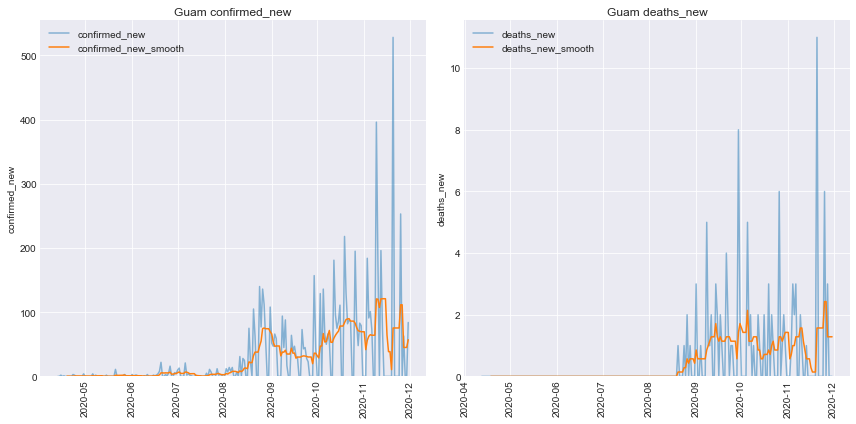

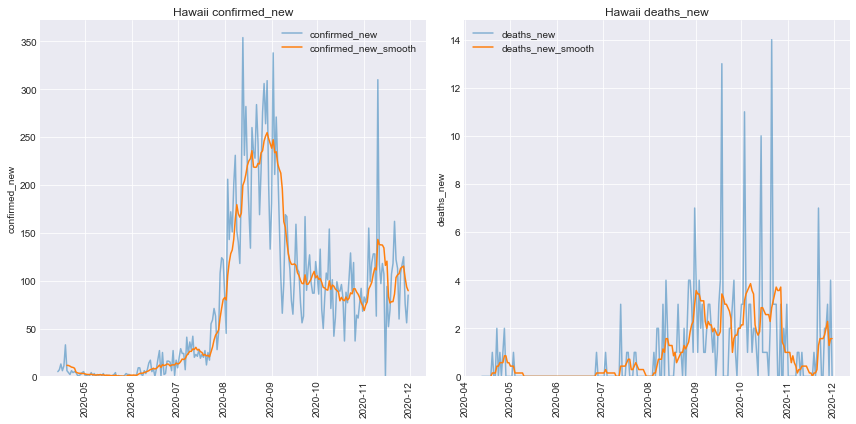

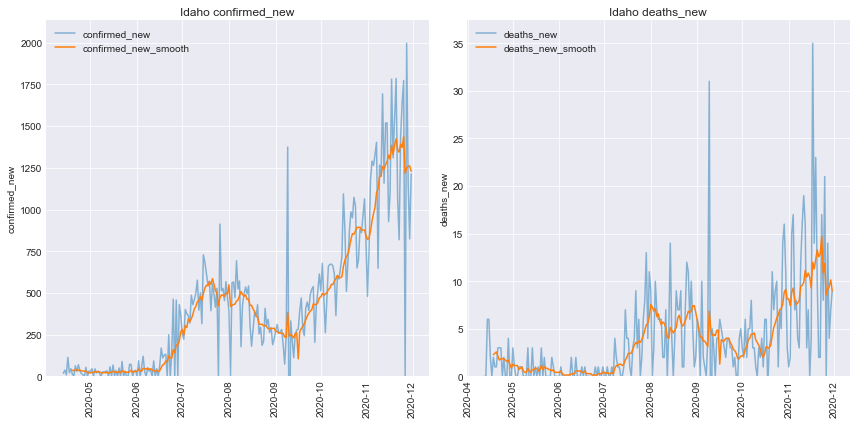

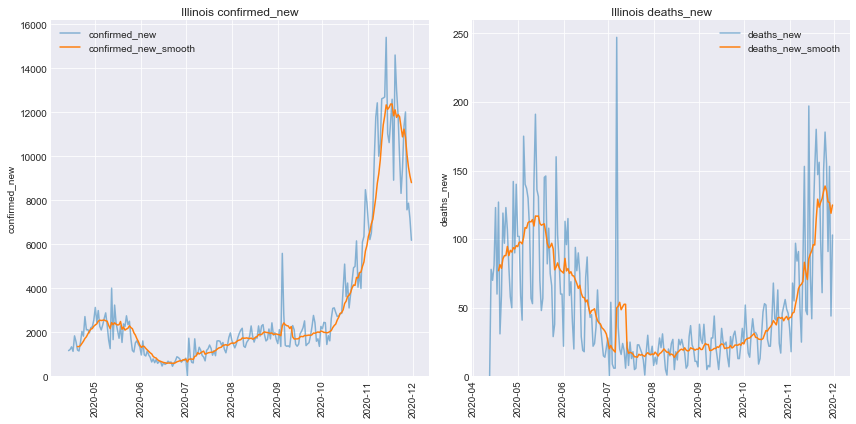

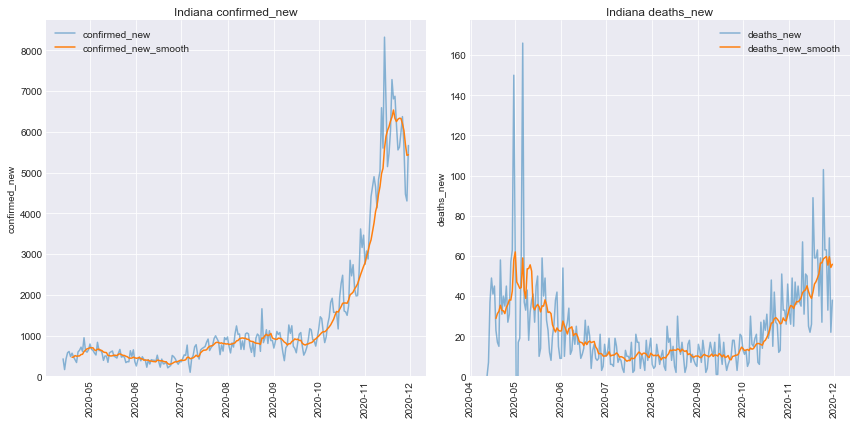

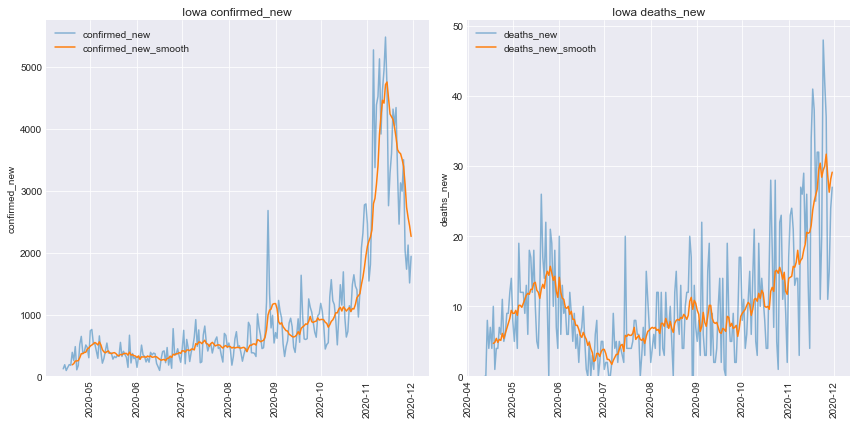

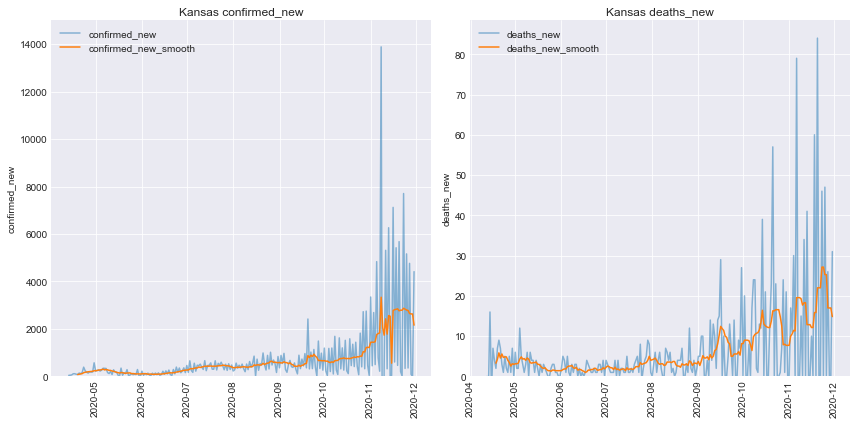

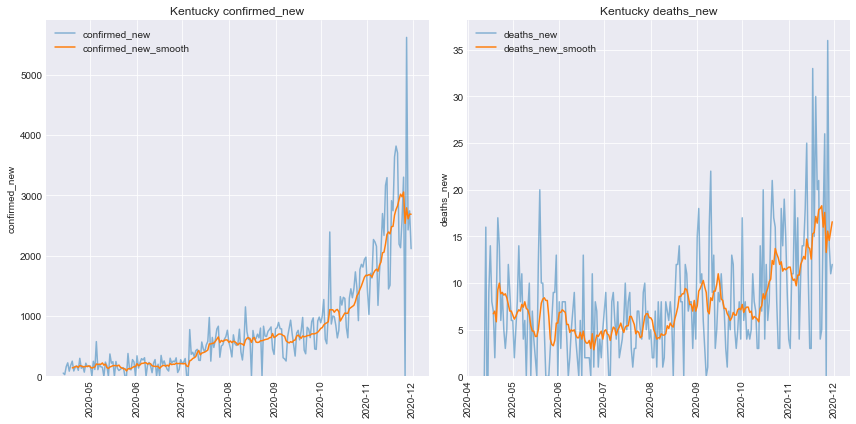

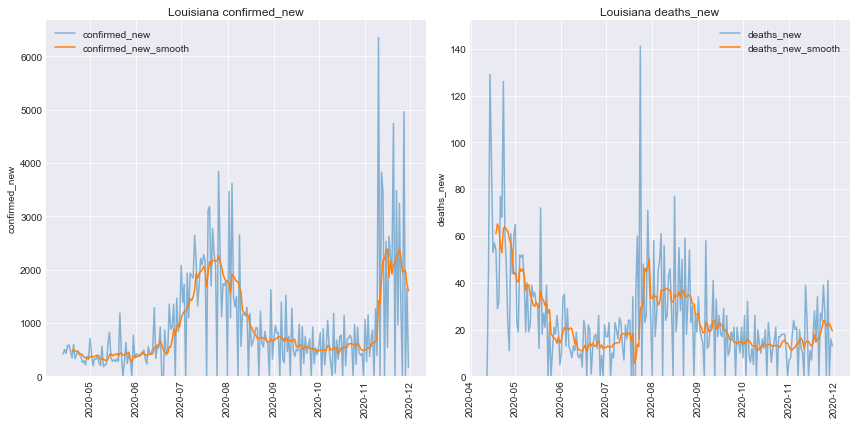

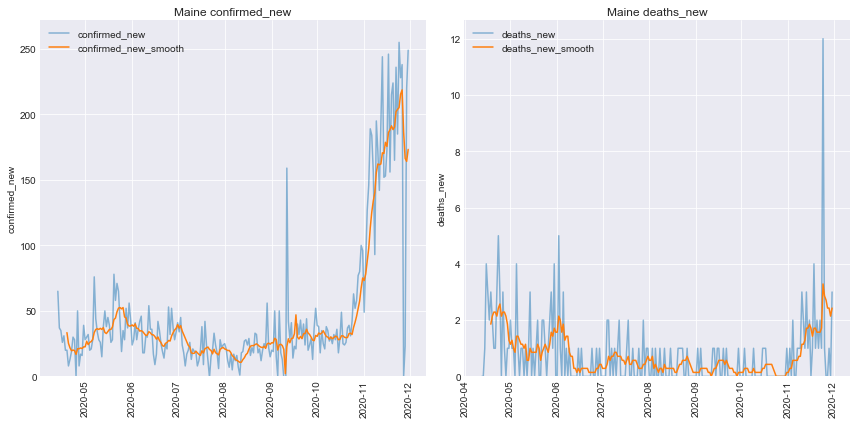

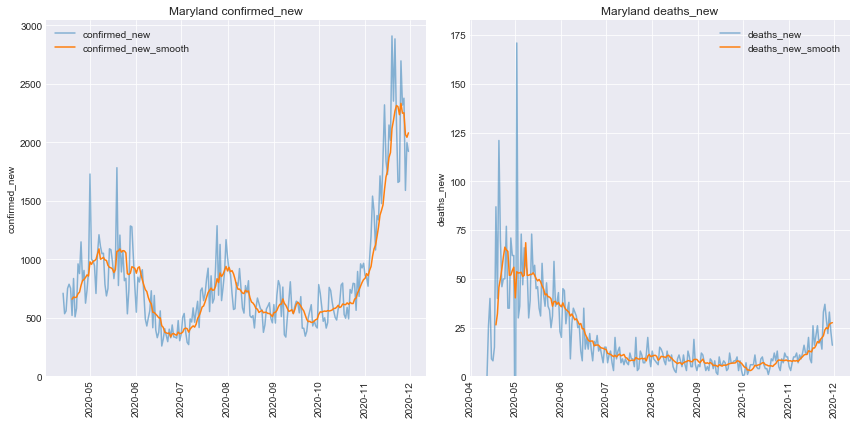

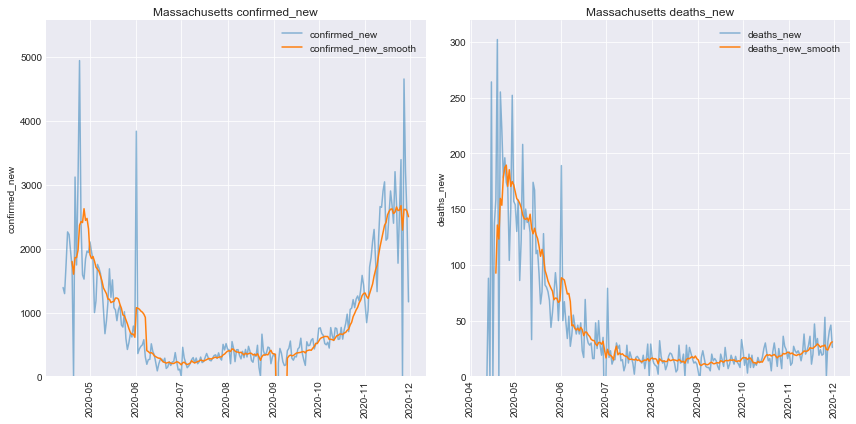

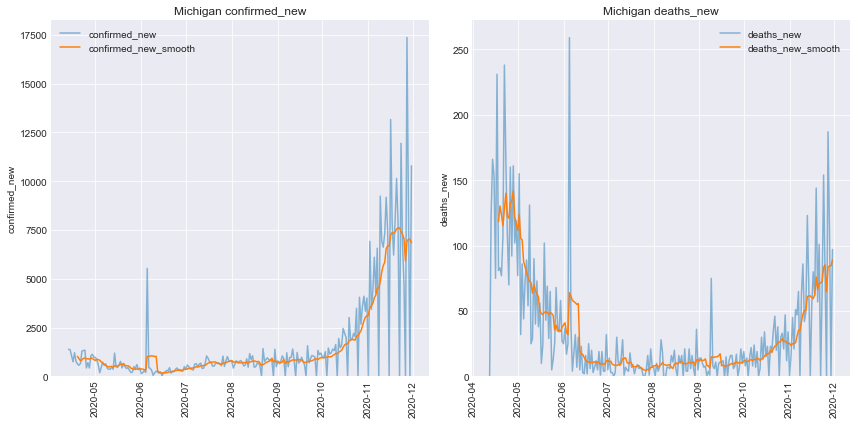

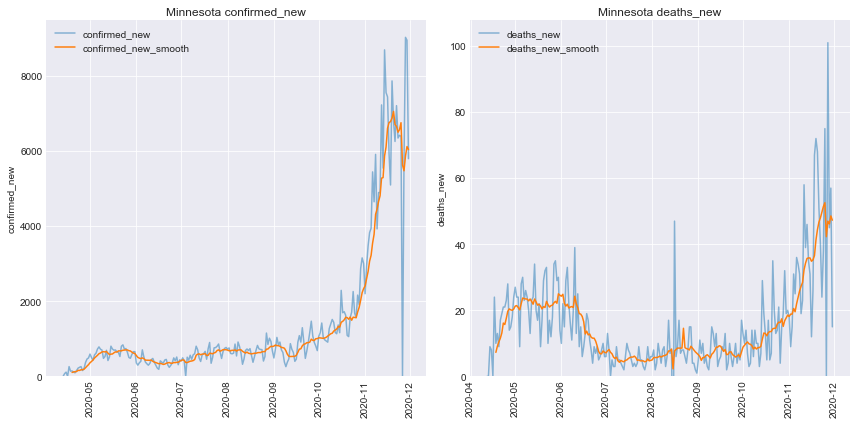

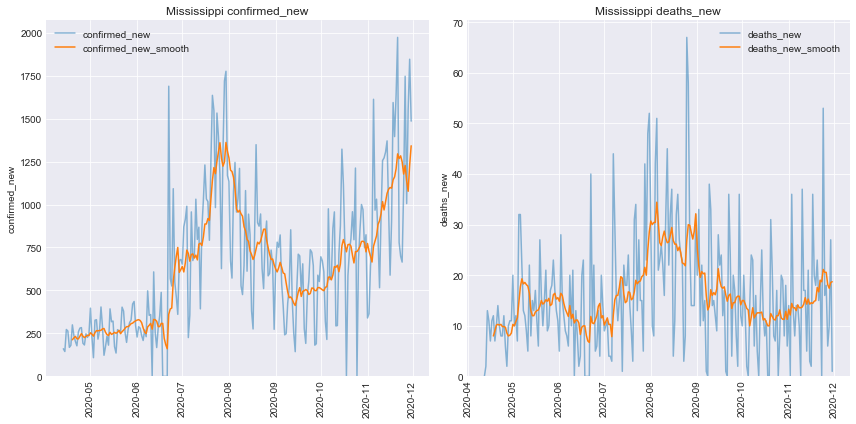

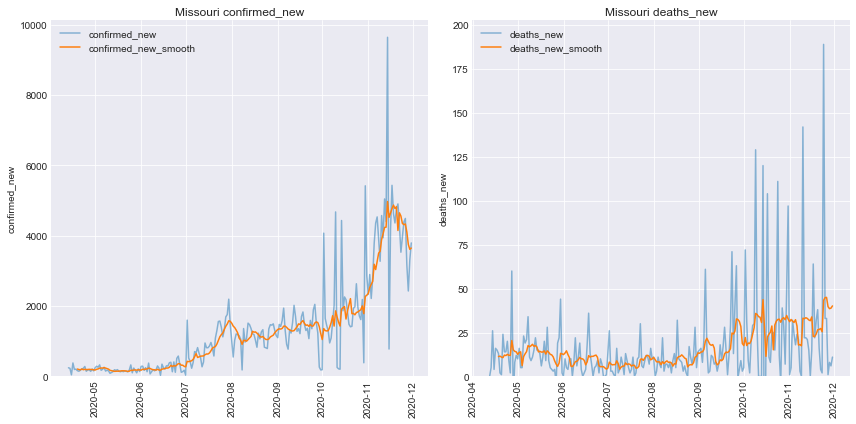

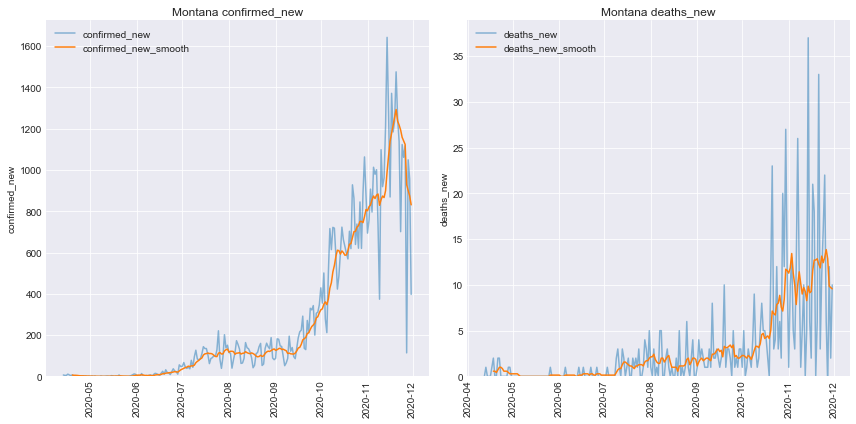

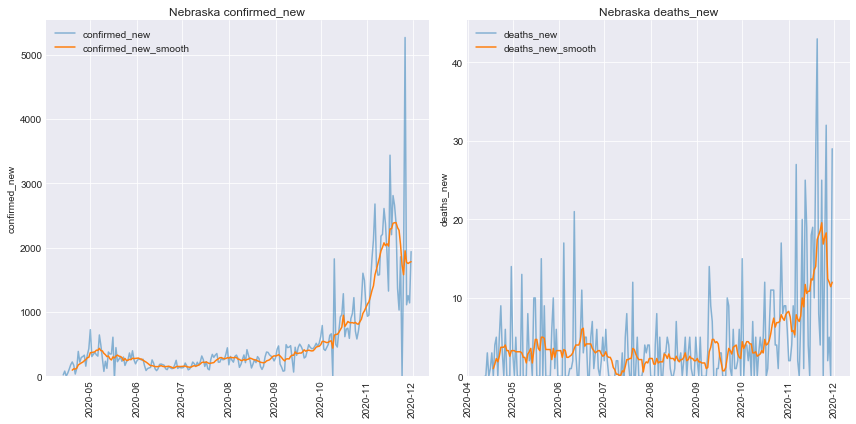

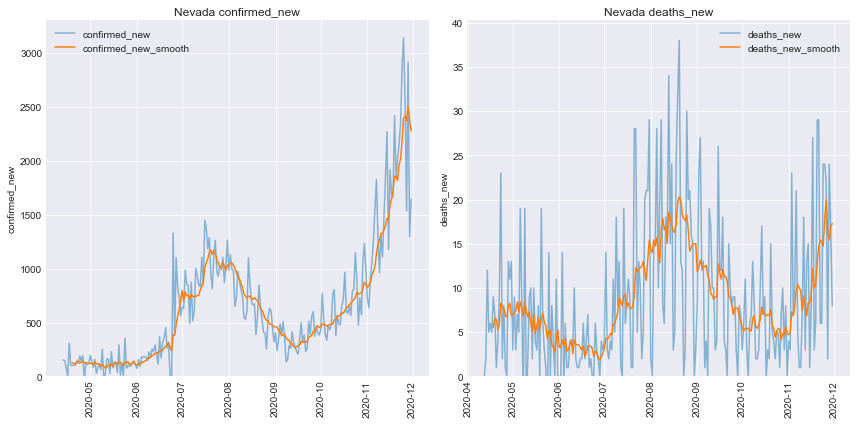

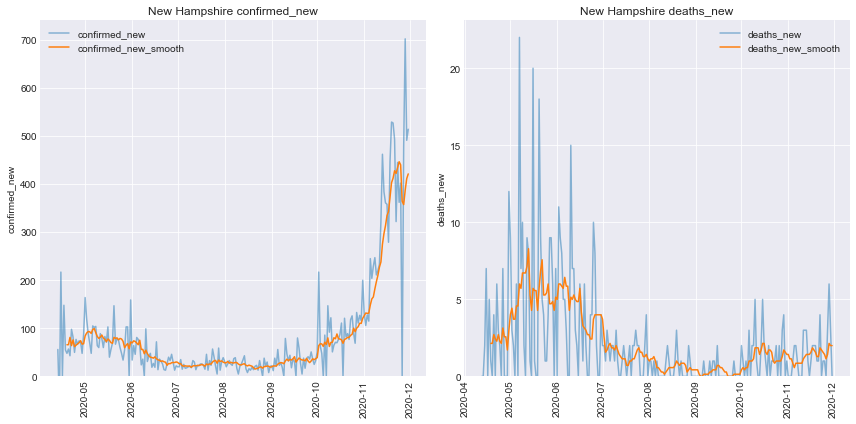

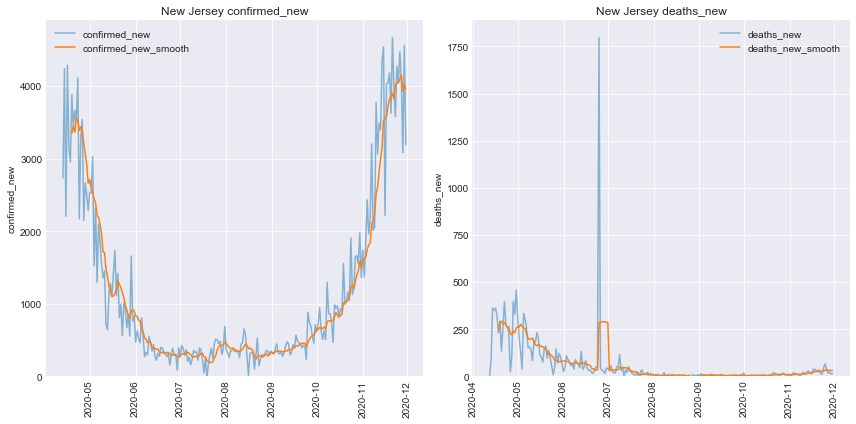

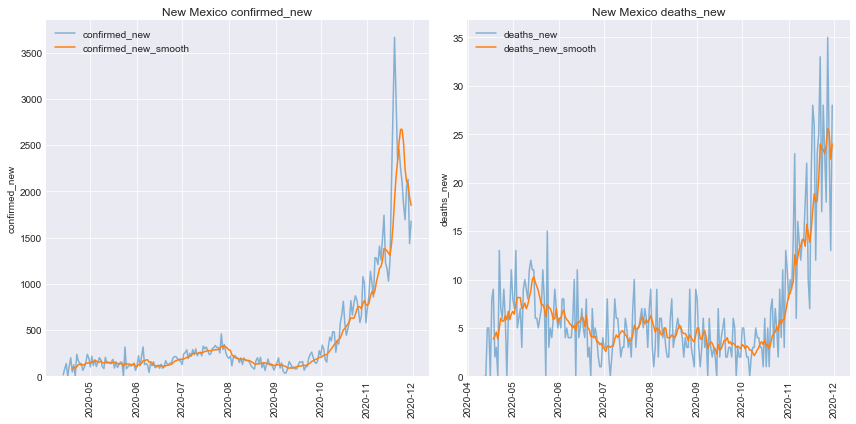

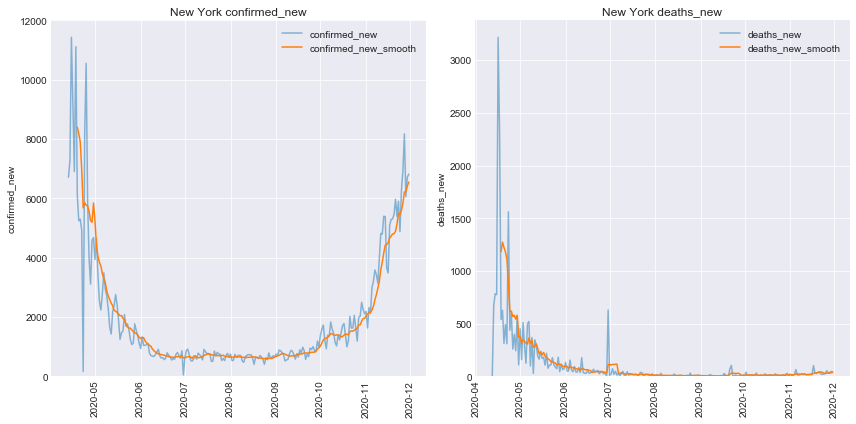

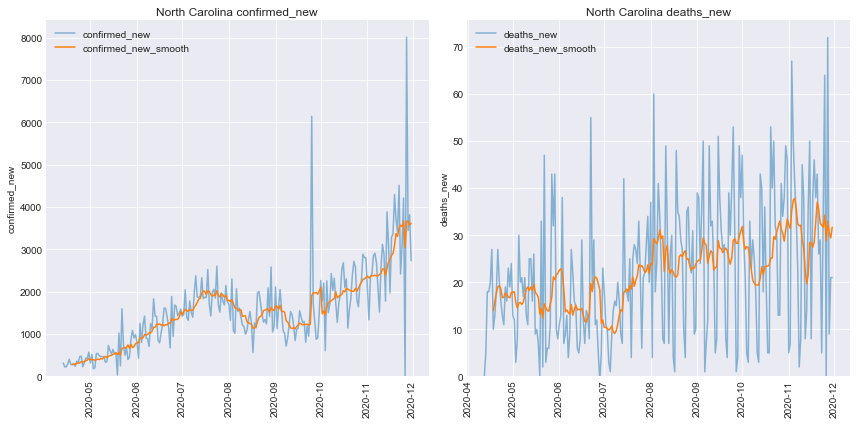

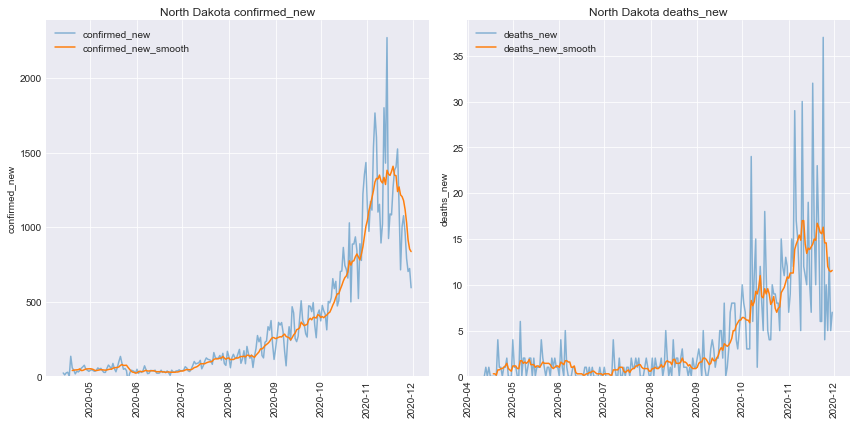

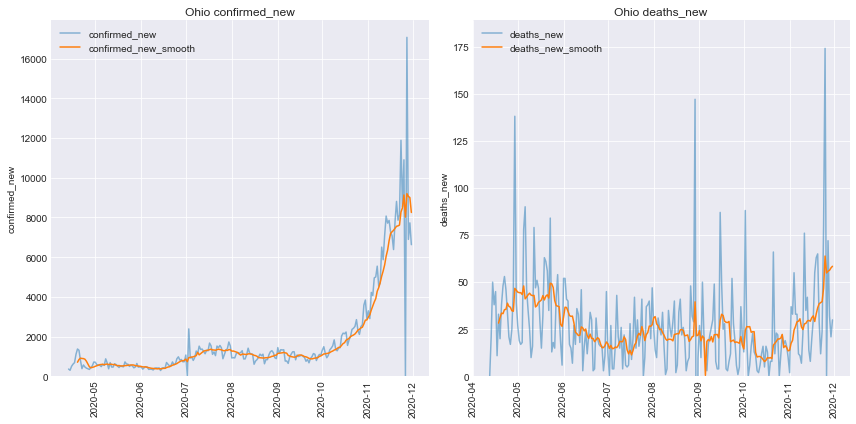

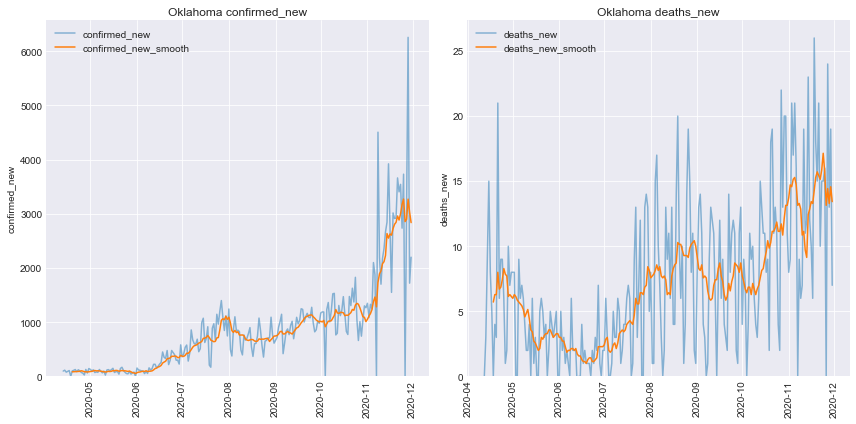

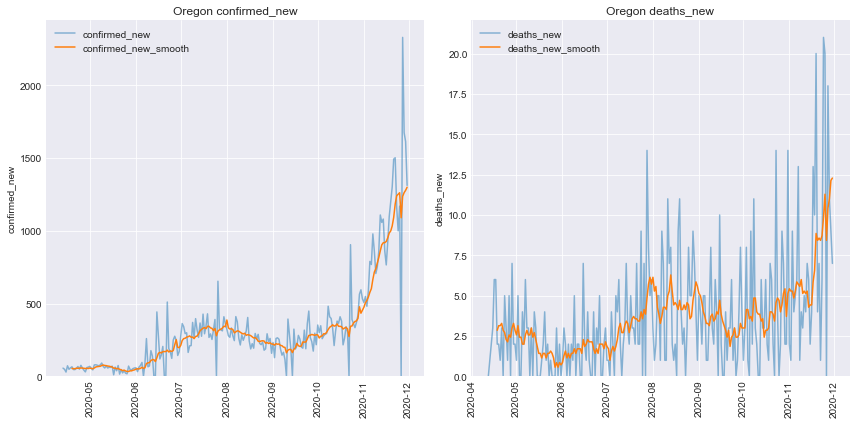

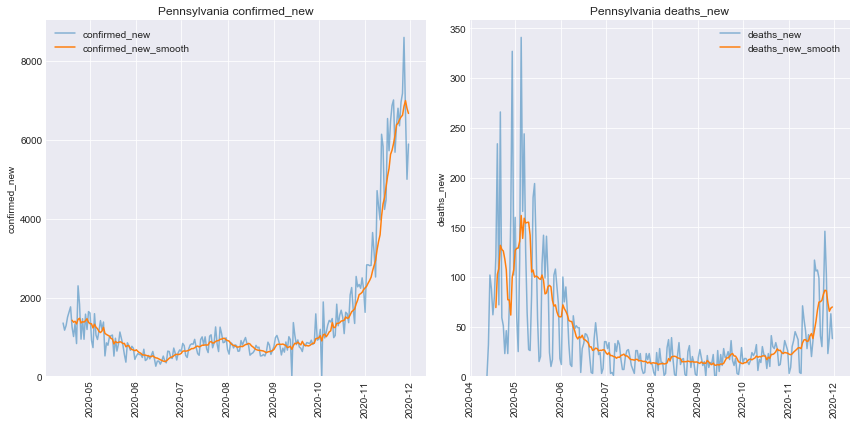

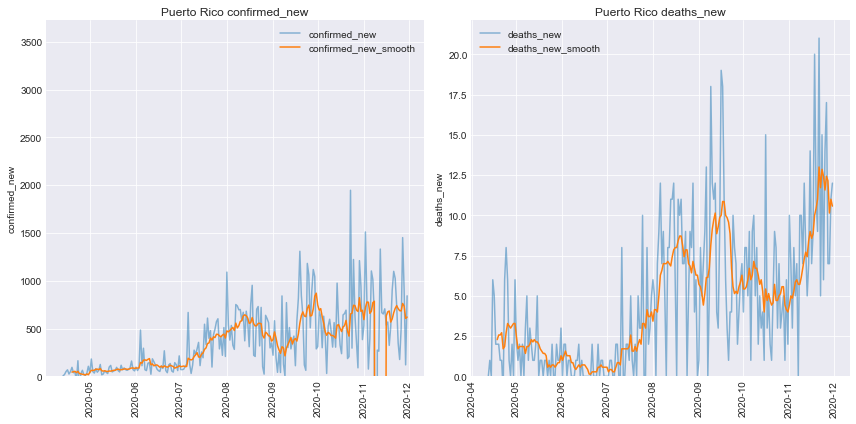

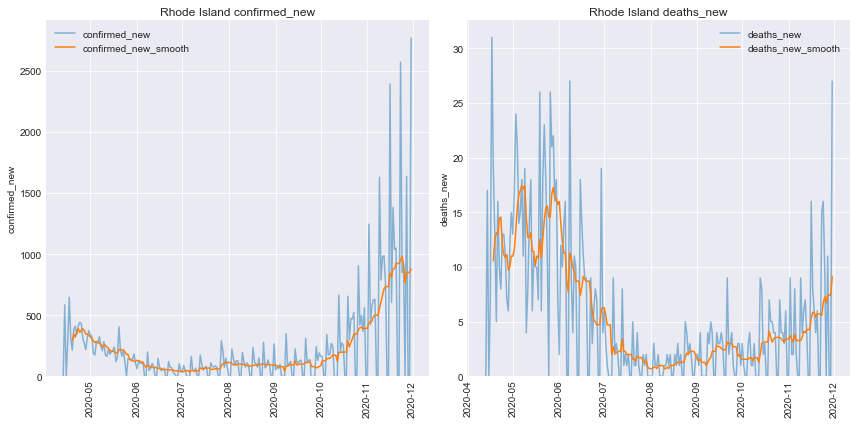

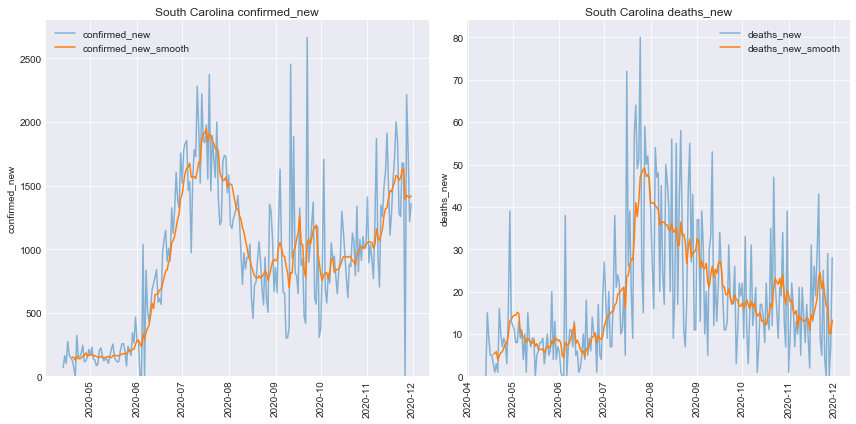

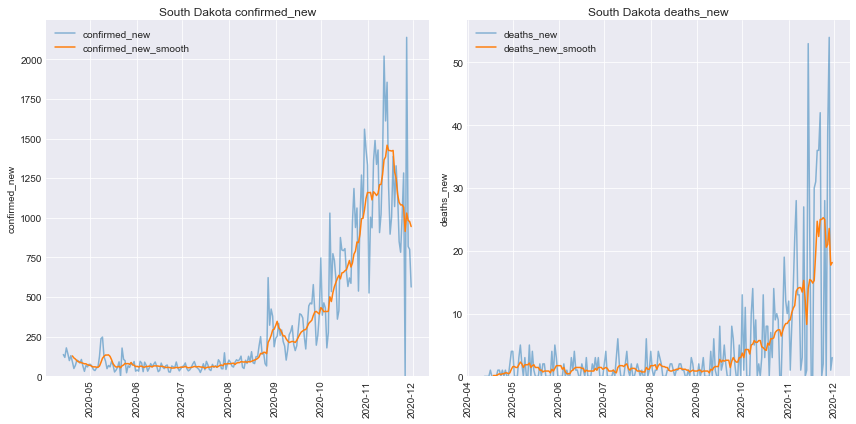

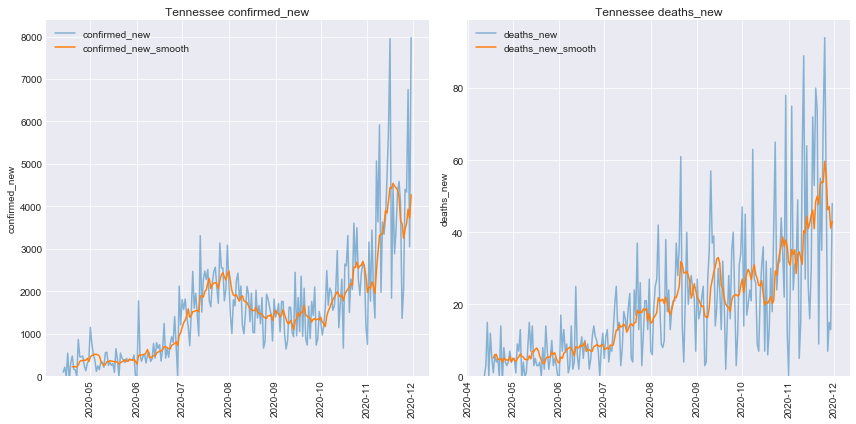

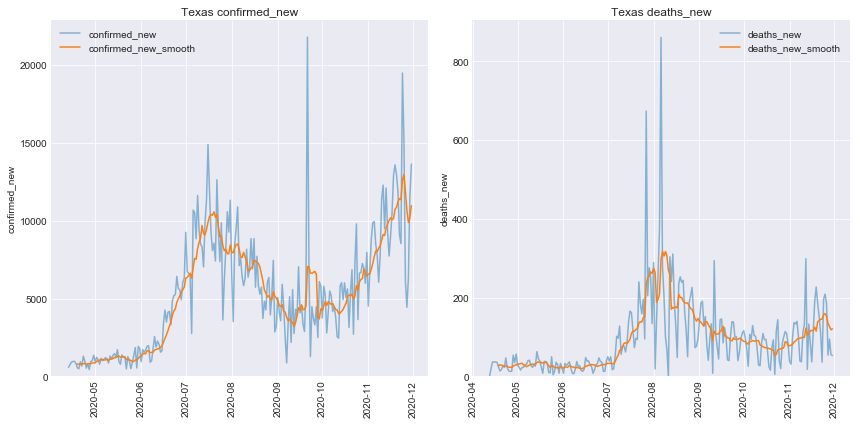

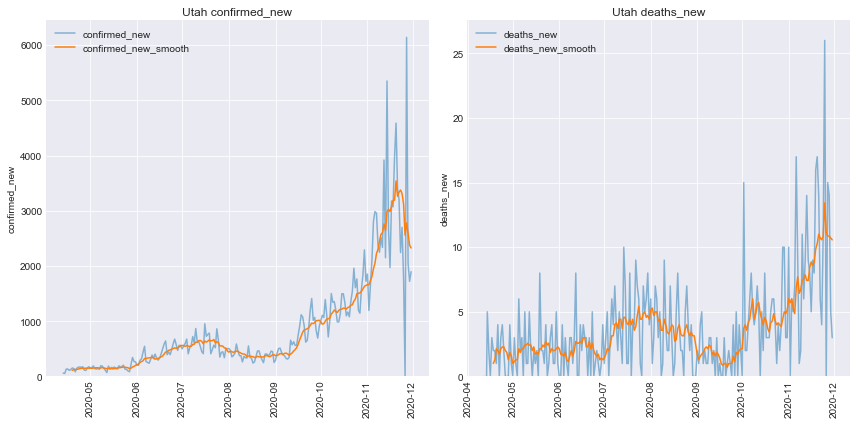

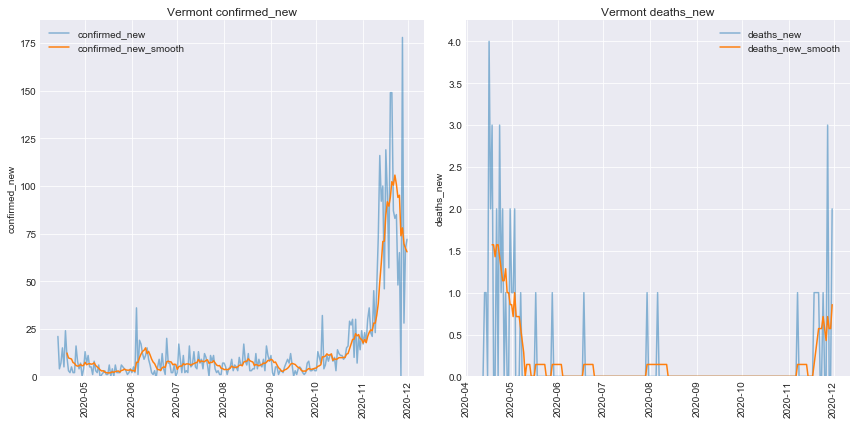

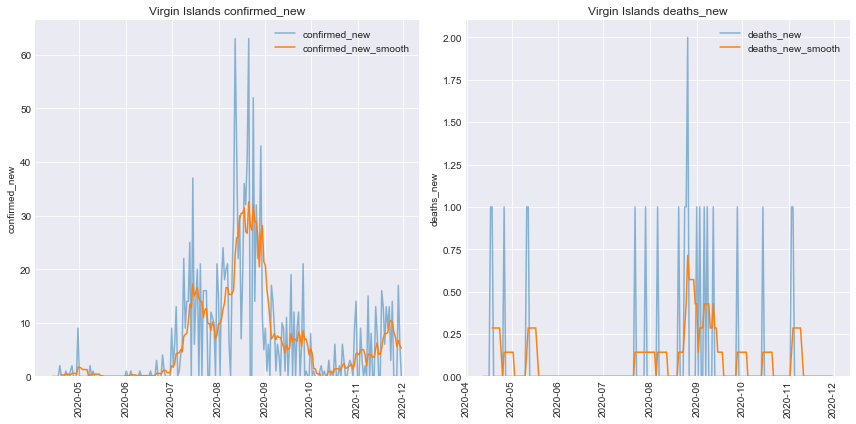

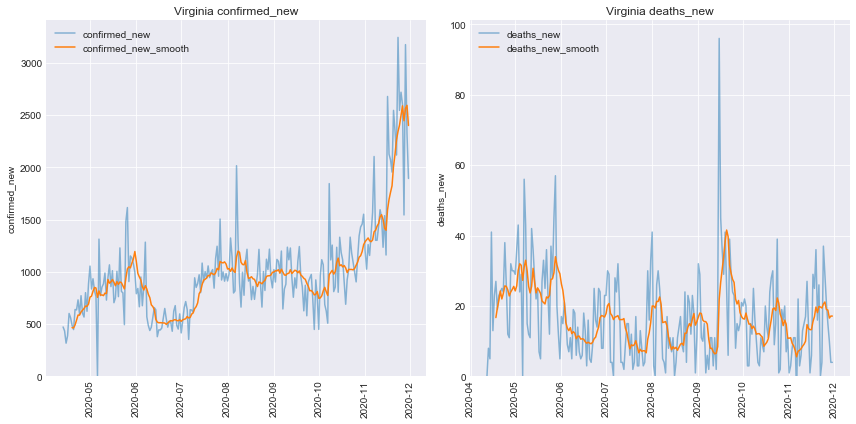

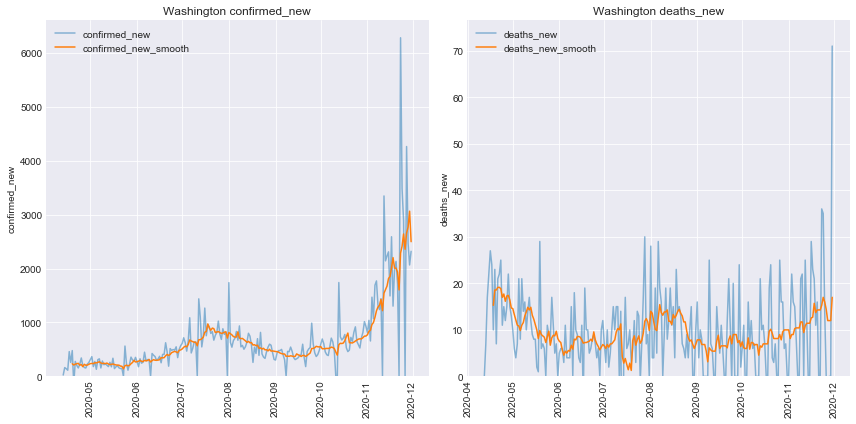

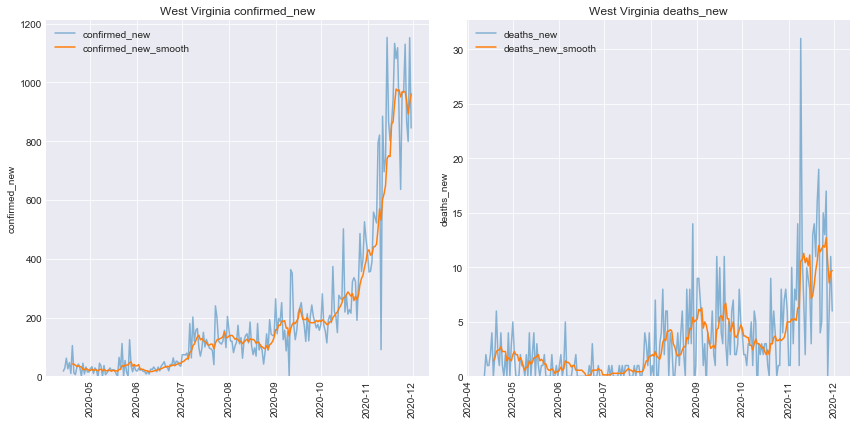

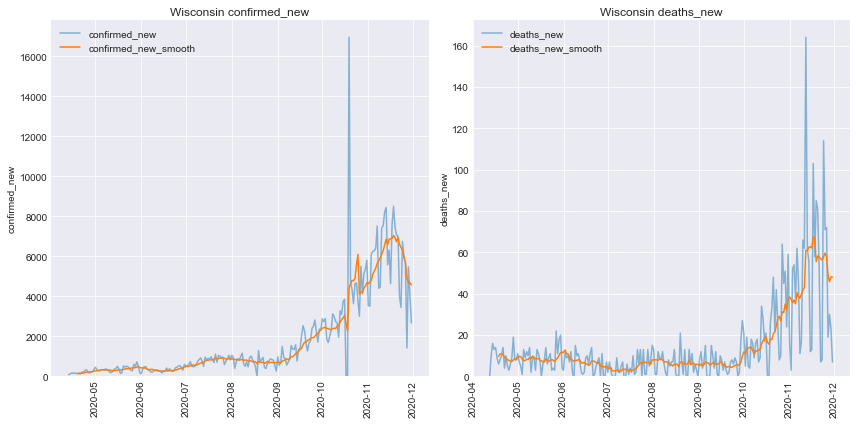

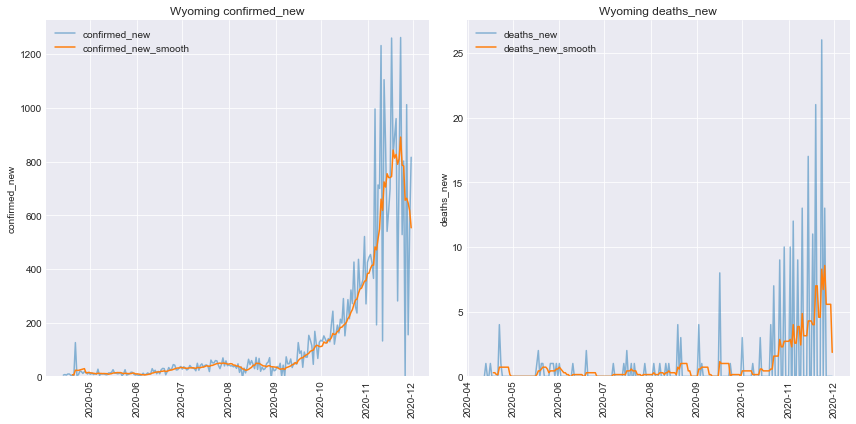

In [311]:


#plot_smoothed_trend(dfp_us_g, ['Washington', 'Ohio', 'California', 'Texas', 'Minnesota', 'Wisconsin'], cols_plot=['confirmed_new', 'deaths_new'])

plot_smoothed_trend(dfp_us_g, states_minimum_thresh, cols_plot=['confirmed_new', 'deaths_new'])

### All states sorted by new deaths DESC

In [312]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0                   Maryland              0.054673                 0.026467
1                     Oregon              0.054177                 0.025591
2                 New Jersey              0.051331                 0.021698
3                     Nevada              0.050887                 0.035444
4               Pennsylvania              0.050085                 0.033829
5                       Ohio              0.047452                 0.026850
6                Connecticut              0.046762                 0.009354
7               Rhode Island              0.039209                 0.014179
8                   Colorado              0.038128                 0.009246
9                      Maine              0.037734                 0.006668
10                New Mexico              0.035108                 0.035129
11                  New York              0.034759                 0.030701
12              South Dakota              0.033746                -0.021028
13                  Virginia              0.033570                 0.035656
14                  Illinois              0.033469                -0.011638
15                California              0.031367                 0.046328
16                 Louisiana              0.029720                 0.004239
17                    Alaska              0.029119                 0.007734
18                      Iowa              0.028078                -0.032434
19                  Michigan              0.027969                 0.007764
20               Puerto Rico              0.027120                 0.000347
21                 Minnesota              0.025270                 0.007703
22                      Utah              0.024440                -0.002574
23                   Indiana              0.021207                 0.008908
24               Mississippi              0.019034                 0.012239
25                  Nebraska              0.019027                -0.009699
26                  Oklahoma              0.017304                 0.020397
27                   Florida              0.017153                 0.024350
28                    Kansas              0.017039                 0.019608
29                   Wyoming              0.017010                -0.003911
30                Washington              0.015347                 0.035369
31            North Carolina              0.015107                 0.023223
32                     Texas              0.014962                 0.011368
33                  Missouri              0.014927                -0.005949
34                  Delaware              0.014915                 0.038107
35                  Arkansas              0.013780                 0.005956
36             New Hampshire              0.013587                 0.030472
37                 Tennessee              0.013444                 0.000232
38                   Montana              0.012212                 0.001843
39             Massachusetts              0.011914                 0.010428
40                  Kentucky              0.011778                 0.017174
41                   Arizona              0.008080                 0.040868
42            South Carolina              0.006809                 0.009622
43                    Hawaii              0.003511                -0.015275
44             West Virginia              0.002099                 0.026064
45                      Guam              0.001081                -0.031893
46            Grand Princess              0.000000                 0.000000
47          Diamond Princess              0.000000                 0.000000
48  Northern Mariana Islands              0.000000                 0.000000
49                   Vermont              0.000000                 0.025742
50            Virgin Islands              0.000000                 0.030865
51            American Samoa              0.000000                 0.00

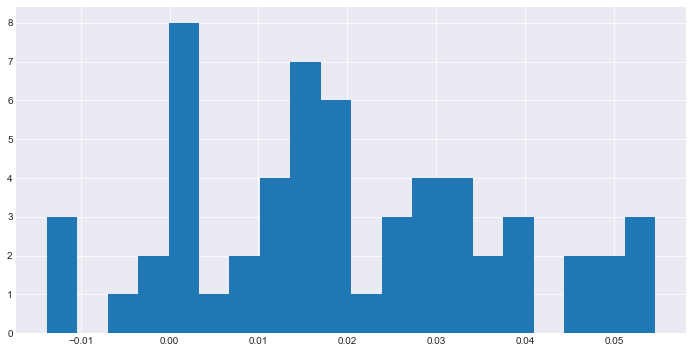

In [313]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

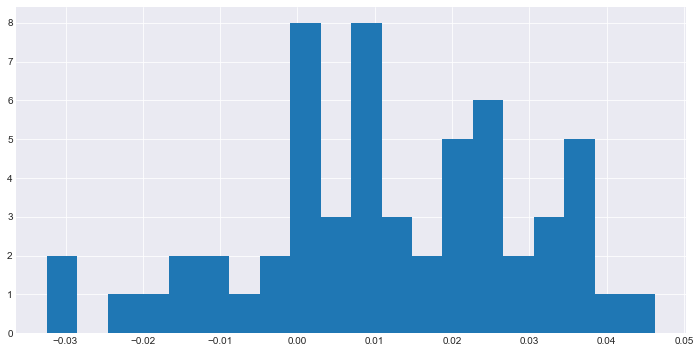

In [314]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [315]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0      Maryland              0.054673                 0.026467
1        Oregon              0.054177                 0.025591
2    New Jersey              0.051331                 0.021698
3        Nevada              0.050887                 0.035444
4  Pennsylvania              0.050085                 0.033829
5          Ohio              0.047452                 0.026850
6   Connecticut              0.046762                 0.009354
7  Rhode Island              0.039209                 0.014179
8      Colorado              0.038128                 0.009246
9         Maine              0.037734                 0.006668

### Which states are increasing in new deaths <u>least</u> quickly?

In [316]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48  Northern Mariana Islands              0.000000                 0.000000
49                   Vermont              0.000000                 0.025742
50            Virgin Islands              0.000000                 0.030865
51            American Samoa              0.000000                 0.000000
52                     Idaho             -0.002428                 0.000727
53      District of Columbia             -0.003166                 0.022591
54                 Wisconsin             -0.004217                -0.016515
55              North Dakota             -0.010984                -0.020416
56                   Georgia             -0.012907                 0.016628
57                   Alabama             -0.013816                 0.022297

### Is there a day-of-the-week effect on new deaths?

Monday -> 0
Sunday -> 6

In [317]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [318]:
deaths_new_col, death_pred_col = 'deaths_new', 'deaths_new_smooth_pred'
confirmed_new_col, confirmed_pred_col = 'confirmed_new', 'confirmed_new_smooth_pred'
dfp_us_dow['death_delta'] = dfp_us_dow[deaths_new_col]- dfp_us_dow[death_pred_col]
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow[death_pred_col]

dfp_us_dow['confirmed_delta'] = dfp_us_dow[confirmed_new_col]- dfp_us_dow[confirmed_pred_col]
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow[confirmed_pred_col]
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.mean, # np.median
                          deaths_new_col: np.mean, 
                          death_pred_col: np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.mean}) # np.median
                    )

In [319]:
dfp_us_dow[dfp_us_dow.state=='Washington'].tail()

state       date country  confirmed  deaths  confirmed_lag1  \
1150  Washington 2020-11-26      US   153906.0  2704.0        153906.0   
1151  Washington 2020-11-27      US   158167.0  2703.0        153906.0   
1152  Washington 2020-11-28      US   160634.0  2703.0        158167.0   
1153  Washington 2020-11-29      US   162700.0  2703.0        160634.0   
1154  Washington 2020-11-30      US   165019.0  2774.0        162700.0   

      deaths_lag1  confirmed_new  deaths_new  mortality_rate  \
1150       2704.0            0.0         0.0        0.017569   
1151       2704.0         4261.0        -1.0        0.017090   
1152       2703.0         2467.0         0.0        0.016827   
1153       2703.0         2066.0         0.0        0.016613   
1154       2703.0         2319.0        71.0        0.016810   

      deaths_new_smooth  confirmed_new_smooth  confirmed_new_smooth_log  \
1150          14.428571           2356.428571                  3.372254   
1151          12.000000           2660.571429                  3.424975   
1152          12.000000           2767.714286                  3.442121   
1153          12.000000           3062.857143                  3.486127   
1154          17.000000           2497.428571                  3.397493   

      deaths_new_smooth_log      unixtime  recovered  active         slope  \
1150               1.159223  1.606349e+09        NaN     NaN  7.655739e-08   
1151               1.079181  1.606435e+09        NaN     NaN  7.655739e-08   
1152               1.079181  1.606522e+09        NaN     NaN  7.655739e-08   
1153               1.079181  1.606608e+09        NaN     NaN  7.655739e-08   
1154               1.230449  1.606694e+09        NaN     NaN  7.655739e-08   

      confirmed_new_smooth_pred  frac_increase_confirmed  \
1150                       2489                 0.035369   
1151                       2577                 0.035369   
1152                       2668                 0.035369   
1153                       2763                 0.035369   
1154                       2860                 0.035369   

      deaths_new_smooth_pred  frac_increase_deaths  dow  death_delta  \
1150                      14              0.015347    3        -14.0   
1151                      14              0.015347    4        -15.0   
1152                      14              0.015347    5        -14.0   
1153                      15              0.015347    6        -15.0   
1154                      15              0.015347    0         56.0   

      death_rel_delta  confirmed_delta  confirmed_rel_delta  
1150        -1.000000          -2489.0            -1.000000  
1151        -1.071429           1684.0             0.653473  
1152        -1.000000           -201.0            -0.075337  
1153        -1.000000           -697.0            -0.252262  
1154         3.733333           -541.0            -0.189161

In [320]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    32.000000         2.306410   45.333333   
379  Washington    1    14.666667         1.202991   26.666667   
380  Washington    2    -0.666667        -0.083333   11.666667   
381  Washington    3    -0.333333         0.063131   12.000000   
382  Washington    4    -3.666667        -0.249917    9.000000   
383  Washington    5   -13.000000        -1.000000    0.000000   
384  Washington    6   -13.333333        -1.000000    0.000000   

     deaths_new_smooth_pred  confirmed_delta  confirmed_rel_delta  
378               13.333333      1076.000000             0.486421  
379               12.000000       647.666667             0.310636  
380               12.333333      -525.333333            -0.369279  
381               12.333333      -212.666667             0.068242  
382               12.666667       784.666667             0.353730  
383               13.000000         5.666667             0.035665  
384               13.333333      -750.666667            -0.297476

In [321]:
# alpha_soft = 0.15
# alpha_hard = 0.8
# for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
#     dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
#     dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
#     p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
#     color = p[0].get_color()
#     plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
#     q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
#     color = q[0].get_color()
#     plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
#     plt.legend(loc='best')
#     plt.axhline(0, color='k')
#     plt.title(f'state={state}')

#     #plt.ylim([-0.5,0.5])
#     #plt.ylim([-2,2])
#     plt.show()

# Cases per capita by state

In [322]:
dfp_state_census = pd.read_csv('supporting_data/nst-est2019-alldata.csv')

In [323]:
dfp_us_g.shape

(13532, 12)

In [324]:
cols_state_pop = ['NAME', 'POPESTIMATE2019'] #'STATE',
dfp_state_census_clean = dfp_state_census[cols_state_pop][dfp_state_census['STATE'] > 0]
#dfp_state_census_clean = dfp_state_census_clean.rename(columns={'STATE': 'STATE_NUMBER'})
dfp_state_census_clean.columns = [x.lower() for x in dfp_state_census_clean.columns]
pop_col = 'population'
cols_state_translate = {'name': 'state', 'popestimate2019': pop_col}
dfp_state_census_clean = dfp_state_census_clean.rename(columns=cols_state_translate)
dfp_us_g1 = dfp_us_g.copy()
dfp_us_g1 = dfp_us_g1.merge(dfp_state_census_clean, on='state', how='inner')

# add normalized columns
norm_factor = 1E6
dfp_us_g1['deaths_new_per_1m'] = dfp_us_g1['deaths_new'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['confirmed_new_per_1m'] = dfp_us_g1['confirmed_new'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['deaths_new_per_1m_smooth'] = dfp_us_g1['deaths_new_smooth'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['confirmed_new_per_1m_smooth'] = dfp_us_g1['confirmed_new_smooth'] / dfp_us_g1[pop_col] * norm_factor

In [325]:
dfp_us_g1.shape

(12116, 17)

<a id='us_state_maps'></a>
# Plot maps

In [326]:
dfp_us_g1_newest = dfp_us_g1[dfp_us_g1.date == dfp_us_g1.date.max()].copy()
#print(f'There are {len(dfp_us_g1_newest.columns)}')
cols1 = set(dfp_us_g1_newest.columns)
dfp_us_g1_newest = dfp_us_g1_newest.merge(dfp_state_codes, left_on='state', right_on='state_name', how='left')
#print(f'After merge there are {len(dfp_us_g1_newest.columns)}')
cols2 = set(dfp_us_g1_newest.columns)

In [327]:
dfp_us_g1_newest = dfp_us_g1_newest.sort_values(by='confirmed_new_per_1m_smooth', ascending=0)
dfp_us_g1_newest.head(10)

date country         state  confirmed  deaths  confirmed_lag1  \
7  2020-11-30      US  North Dakota      79252     933         78658.0   
51 2020-11-30      US     Minnesota     318763    3652        312969.0   
14 2020-11-30      US  South Dakota      80464     946         79900.0   
23 2020-11-30      US       Wyoming      33305     215         32489.0   
12 2020-11-30      US      Nebraska     128407    1018        126466.0   
4  2020-11-30      US    New Mexico      97095    1568         95417.0   
38 2020-11-30      US        Alaska      32576     121         32065.0   
24 2020-11-30      US  Rhode Island      56723    1373         53954.0   
42 2020-11-30      US       Indiana     338977    5723        333312.0   
22 2020-11-30      US     Wisconsin     411730    3494        409054.0   

    deaths_lag1  confirmed_new  deaths_new  mortality_rate  deaths_new_smooth  \
7         926.0          594.0         7.0        0.011773          11.571429   
51       3637.0         5794.0        15.0        0.011457          47.285714   
14        943.0          564.0         3.0        0.011757          18.142857   
23        215.0          816.0         0.0        0.006455           1.857143   
12        989.0         1941.0        29.0        0.007928          12.000000   
4        1540.0         1678.0        28.0        0.016149          24.000000   
38        121.0          511.0         0.0        0.003714           2.571429   
24       1346.0         2769.0        27.0        0.024205           9.142857   
42       5685.0         5665.0        38.0        0.016883          55.857143   
22       3487.0         2676.0         7.0        0.008486          48.000000   

    confirmed_new_smooth  population  deaths_new_per_1m  confirmed_new_per_1m  \
7             836.428571      762062           9.185604            779.464138   
51           6037.571429     5639632           2.659748           1027.371999   
14            945.142857      884659           3.391137            637.533784   
23            553.428571      578759           0.000000           1409.913280   
12           1783.714286     1934408          14.991667           1003.407761   
4            1849.571429     2096829          13.353497            800.256006   
38            614.714286      731545           0.000000            698.521622   
24            878.571429     1059361          25.487062           2613.839853   
42           5437.714286     6732219           5.644498            841.475894   
22           4576.714286     5822434           1.202246            459.601603   

    deaths_new_per_1m_smooth  confirmed_new_per_1m_smooth    state_name  \
7                  15.184366                  1097.585986  North Dakota   
51                  8.384539                  1070.561240     Minnesota   
14                 20.508306                  1068.369685  South Dakota   
23                  3.208836                   956.233201       Wyoming   
12                  6.203448                   922.098278      Nebraska   
4                  11.445855                   882.080240    New Mexico   
38                  3.515065                   840.295929        Alaska   
24                  8.630540                   829.340922  Rhode Island   
42                  8.296988                   807.715002       Indiana   
22                  8.243975                   786.048289     Wisconsin   

   two_letter_code  
7               ND  
51              MN  
14              SD  
23              WY  
12              NE  
4               NM  
38              AK  
24              RI  
42              IN  
22              WI

In [328]:
def plot_us_map(df, plot_col, color='Reds', col_state_abbrev='two_letter_code'):
    # this was adapted from example at https://plotly.com/python/choropleth-maps/
    import plotly.graph_objects as go
    fig = go.Figure(data=go.Choropleth(
        locations=df[col_state_abbrev], #df['code'], # Spatial coordinates
        z = df[plot_col].astype(float), # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = color,
        colorbar_title = plot_col,
    ))

    fig.update_layout(
        title_text = plot_col,
        geo_scope='usa', # limite map scope to USA
    )

    fig.show()
    return None

In [329]:
dfp_us_g1_newest.head()

date country         state  confirmed  deaths  confirmed_lag1  \
7  2020-11-30      US  North Dakota      79252     933         78658.0   
51 2020-11-30      US     Minnesota     318763    3652        312969.0   
14 2020-11-30      US  South Dakota      80464     946         79900.0   
23 2020-11-30      US       Wyoming      33305     215         32489.0   
12 2020-11-30      US      Nebraska     128407    1018        126466.0   

    deaths_lag1  confirmed_new  deaths_new  mortality_rate  deaths_new_smooth  \
7         926.0          594.0         7.0        0.011773          11.571429   
51       3637.0         5794.0        15.0        0.011457          47.285714   
14        943.0          564.0         3.0        0.011757          18.142857   
23        215.0          816.0         0.0        0.006455           1.857143   
12        989.0         1941.0        29.0        0.007928          12.000000   

    confirmed_new_smooth  population  deaths_new_per_1m  confirmed_new_per_1m  \
7             836.428571      762062           9.185604            779.464138   
51           6037.571429     5639632           2.659748           1027.371999   
14            945.142857      884659           3.391137            637.533784   
23            553.428571      578759           0.000000           1409.913280   
12           1783.714286     1934408          14.991667           1003.407761   

    deaths_new_per_1m_smooth  confirmed_new_per_1m_smooth    state_name  \
7                  15.184366                  1097.585986  North Dakota   
51                  8.384539                  1070.561240     Minnesota   
14                 20.508306                  1068.369685  South Dakota   
23                  3.208836                   956.233201       Wyoming   
12                  6.203448                   922.098278      Nebraska   

   two_letter_code  
7               ND  
51              MN  
14              SD  
23              WY  
12              NE

In [330]:
dfp_us_g1_newest[dfp_us_g1_newest.state == 'Washington']

date country       state  confirmed  deaths  confirmed_lag1  \
20 2020-11-30      US  Washington     165019    2774        162700.0   

    deaths_lag1  confirmed_new  deaths_new  mortality_rate  deaths_new_smooth  \
20       2703.0         2319.0        71.0         0.01681               17.0   

    confirmed_new_smooth  population  deaths_new_per_1m  confirmed_new_per_1m  \
20           2497.428571     7614893           9.323834            304.534811   

    deaths_new_per_1m_smooth  confirmed_new_per_1m_smooth  state_name  \
20                  2.232467                   327.966338  Washington   

   two_letter_code  
20              WA

In [331]:
plot_us_map(dfp_us_g1_newest, plot_col='confirmed_new_per_1m_smooth')

In [332]:
plot_us_map(dfp_us_g1_newest, plot_col='deaths_new_per_1m_smooth')

In [333]:
dfp_us_g1_newest = dfp_us_g1_newest.merge(dfp_us_frac_new_increase, on='state', how='left')

In [334]:
plot_us_map(dfp_us_g1_newest, plot_col='frac_increase_confirmed')

In [335]:
plot_us_map(dfp_us_g1_newest, plot_col='frac_increase_deaths')

# County level

In [336]:
os.getcwd()

'/Users/tboats/Dropbox (Facebook)/personal/data_sciencey/covid_19/analysis'

In [337]:
dfp_king_raw = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-22-2020.csv')

In [338]:
dfp_king_raw.head()

FIPS         Admin2 Province_State Country_Region    Last_Update  \
0  36061.0  New York City       New York             US  3/22/20 23:45   
1  36059.0         Nassau       New York             US  3/22/20 23:45   
2  36119.0    Westchester       New York             US  3/22/20 23:45   
3  36103.0        Suffolk       New York             US  3/22/20 23:45   
4  36087.0       Rockland       New York             US  3/22/20 23:45   

         Lat      Long_  Confirmed  Deaths  Recovered  Active  \
0  40.767273 -73.971526       9654      63          0       0   
1  40.740665 -73.589419       1900       4          0       0   
2  41.162784 -73.757417       1873       0          0       0   
3  40.883201 -72.801217       1034       9          0       0   
4  41.150279 -74.025605        455       1          0       0   

                  Combined_Key  
0  New York City, New York, US  
1         Nassau, New York, US  
2    Westchester, New York, US  
3        Suffolk, New York, US  
4       Rockland, New York, US

In [339]:
dfp_king_raw.shape

(3418, 12)

In [340]:
dfp_king_raw[(dfp_king_raw.Country_Region == 'US') & (dfp_king_raw.Admin2 == 'King')]

FIPS Admin2 Province_State Country_Region    Last_Update        Lat  \
45    53033.0   King     Washington             US  3/22/20 23:45  47.491379   
2843  48269.0   King          Texas             US  3/22/20 23:45  33.616438   

           Long_  Confirmed  Deaths  Recovered  Active          Combined_Key  
45   -121.834613       1040      75          0       0  King, Washington, US  
2843 -100.255806          0       0          0       0       King, Texas, US

In [341]:
dfp_king_raw.columns

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key'],
      dtype='object')

In [342]:
dfp_king_raw.Country_Region.value_counts()

US             3178
China            33
Canada           14
France           10
Australia        10
               ... 
Guinea            1
Ecuador           1
Estonia           1
Ukraine           1
Timor-Leste       1
Name: Country_Region, Length: 167, dtype: int64

In [343]:
datetime.datetime.strptime('01-27-2020', '%m-%d-%Y')

datetime.datetime(2020, 1, 27, 0, 0)

In [344]:
len(data_paths)

233

In [345]:
def clean_county(
    state_base_dir='../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/',
    grouping_cols=['country', 'state', 'county']
):
    # load and clean data from CSSEGIS
    
    data_paths_raw = os.listdir(state_base_dir)
    data_paths = sorted([path for path in data_paths_raw if path.endswith('csv')])
    list_dfp_states = []
    cols_of_interest = ['country', 'state_raw', 'county', 'date', 'confirmed', 'deaths', 'recovered']
    for idx, path in enumerate(data_paths):
        if (idx + 1) % 10 == 0:
            print(f'{idx + 1} of {len(data_paths)} ({100 * (idx + 1) / len(data_paths)}%)')
        
        # check if date is 2020-03-22 or later (schema change)
        file_date = path.split('.')[0]
        file_dt = datetime.datetime.strptime(file_date, '%m-%d-%Y')
        if file_dt < datetime.datetime(2020,3,22):
            continue
        
        full_path = os.path.join(state_base_dir, path)

        # read state data
        dfp_temp = pd.read_csv(full_path)
        cols = list(dfp_temp.columns)
        #print(dfp_temp.columns)

        # clean column names
        cols_translate = {'Country/Region': 'country',
                          'Province/State': 'state_raw',
                          'Confirmed': 'confirmed',
                          'Deaths': 'deaths',
                          'Recovered': 'recovered',
                          'Country_Region': 'country',
                          'Province_State': 'state_raw',
                          'Admin2': 'county',
                          'Last_Update': 'Last Update',
                          'People_Hospitalized': 'people_hospitalized'
                         }
        dfp_temp = dfp_temp.rename(columns=cols_translate)
        
        #dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())

        dfp_temp['date'] = file_dt  #datetime.datetime.strptime(path.split('.')[0], '%m-%d-%Y')
        #dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
        dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
        list_dfp_states.append(dfp_temp[cols_of_interest])
    dfp_us_raw = pd.concat(list_dfp_states)
    dfp_us_raw['state_clean_1'] = dfp_us_raw['state_raw'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

    # load codes to convert two-letter codes to state names
    dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
    dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
    dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

    # get the most appropriate state name
    dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
    dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)
    dfp_us = dfp_us.rename(columns={'state_clean': 'state'})

    # aggregate infections by state
    dfp_us_g = (dfp_us.groupby(['date'] + grouping_cols, as_index=False).
                agg({
                    'confirmed': np.sum,
                    'deaths': np.sum,
                    #'recovered': np.sum,
                   })
               )
    dfp_us_g = dfp_us_g.sort_values(by='date')
    #dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
    #dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
    dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(grouping_cols)['confirmed'].shift(1)
    dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(grouping_cols)['deaths'].shift(1)
    dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
    dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
    dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
    dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']
    
    # smoothed trend
    dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(grouping_cols, as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
    dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(grouping_cols, as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
    return dfp_us_g

In [346]:
dfp_county_g = clean_county()

10 of 314 (3.1847133757961785%)
20 of 314 (6.369426751592357%)
30 of 314 (9.554140127388536%)
40 of 314 (12.738853503184714%)
50 of 314 (15.92356687898089%)
60 of 314 (19.10828025477707%)
70 of 314 (22.29299363057325%)
80 of 314 (25.477707006369428%)
90 of 314 (28.662420382165607%)
100 of 314 (31.84713375796178%)
110 of 314 (35.031847133757964%)
120 of 314 (38.21656050955414%)
130 of 314 (41.40127388535032%)
140 of 314 (44.5859872611465%)
150 of 314 (47.77070063694268%)
160 of 314 (50.955414012738856%)
170 of 314 (54.140127388535035%)
180 of 314 (57.32484076433121%)
190 of 314 (60.50955414012739%)
200 of 314 (63.69426751592356%)
210 of 314 (66.87898089171975%)
220 of 314 (70.06369426751593%)
230 of 314 (73.2484076433121%)
240 of 314 (76.43312101910828%)
250 of 314 (79.61783439490446%)
260 of 314 (82.80254777070064%)
270 of 314 (85.98726114649682%)
280 of 314 (89.171974522293%)
290 of 314 (92.35668789808918%)
300 of 314 (95.54140127388536%)
310 of 314 (98.72611464968153%)


In [347]:
def plot_county(state, county):
    dfp_county_oi = dfp_county_g[(dfp_county_g.state == state) & (dfp_county_g.county == county)]
    plot_smoothed_trend(dfp_county_oi, [county], cols_plot=['confirmed_new', 'deaths_new'], state_col='county')
    return dfp_county_oi

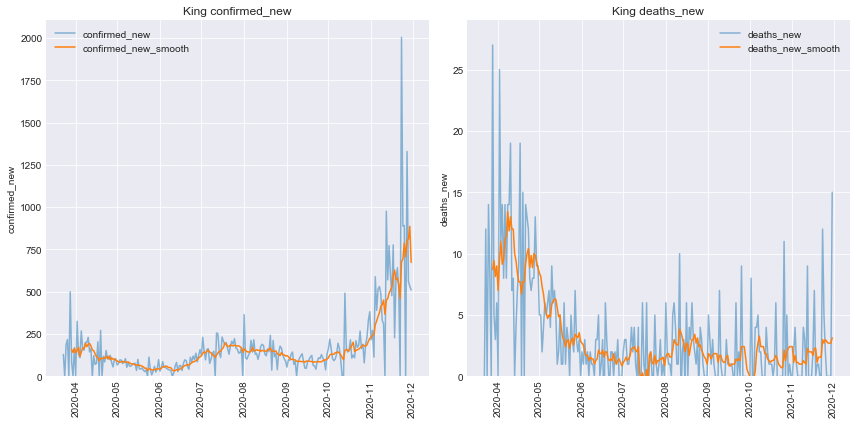

In [348]:
dfp_king = plot_county('Washington', 'King')

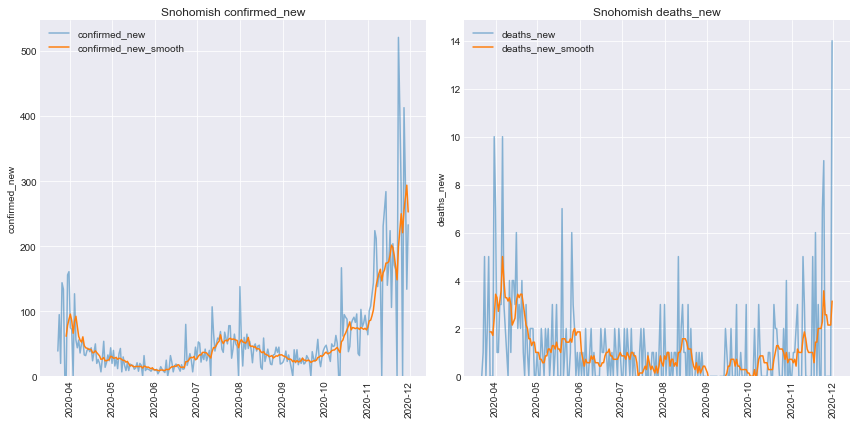

In [349]:
dfp_sno = plot_county('Washington', 'Snohomish')

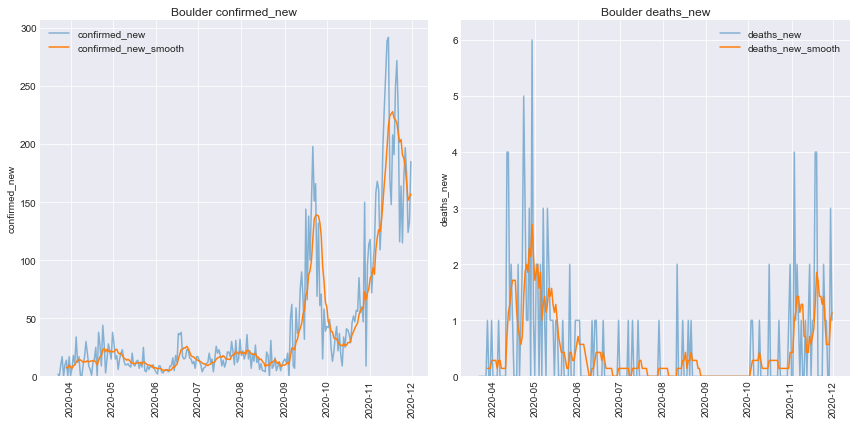

In [350]:
_ = plot_county('Colorado', 'Boulder')

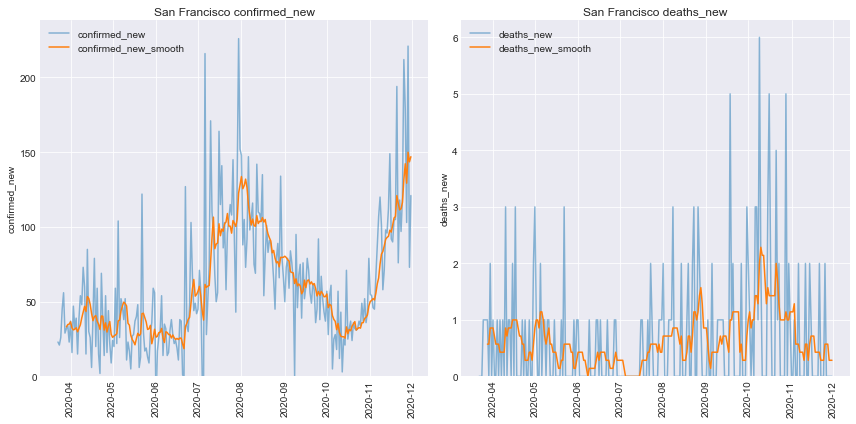

In [351]:
_ = plot_county('California', 'San Francisco')